In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"

datos = pd.read_csv(ruta+"datosCoordenados_CS.csv",sep=",")
clusters = pd.read_csv(ruta+"clusters.csv",sep=",")
coor_SIATA = pd.read_csv(ruta+"coordenadas_SIATA.csv",sep=",")
coor_CS = pd.read_csv(ruta+"coordenadas_CS.csv",sep=",")
datos_SIATA = pd.read_csv(ruta+"datos_SIATA.csv",sep=",")


fecha = "2020-02-01"
fechaSIATA = "01-01-20"
hora = "00:01:00"  # No se está usando
estacionSIATA = 80 #

# 1. FILTRADO DE DATOS ************************************************************

# 1.1 Exportación de los datos necesarios de los archivos
pm25 = datos.loc[:,["codigoSerial", "fecha", "hora", "pm25_df", "pm25_nova"]]
#pm25 = pm25.loc[pm25.loc[:,"hora"] == hora]
horas = pm25.hora.unique().tolist()
#horas = datos_SIATA.hora.unique().tolist()
pm25 = pm25.loc[pm25.loc[:,"fecha"] == fecha]
pm25.reset_index(inplace=True, drop=True)

# 1.2 Tomar los nodos del cluster y pasarlos a una lista.
#print(clusters.nodosCS.loc[clusters['codigoSIATA']==48].values.tolist()[0])
# 1. Se toma el daraframe de clusters y toma la fila que coincide con el valor de la estación,
# el resultado es índice y los valores, por lo que se toman solo los valores con el .value
# luego se converte a una lista y se toma la posición 0, esto es un string
# por ultimo se agregan el split y el strip para elimiar las llaves y tomar las comas como separador de la lista.  
nodos_CS = clusters.nodosCS.loc[clusters['codigoSIATA']==estacionSIATA].values.tolist()[0].strip('][').split(', ')
nodos_CS = [int(x) for x in nodos_CS]
nodos_CS.sort()


# 1.3 Filtrado de datos solo de los nodos del cluster
pm25_c = pd.DataFrame(columns=["codigoSerial", "fecha", "hora", "pm25_df", "pm25_nova"])
for i in nodos_CS:
    pm25_c = pd.concat([pm25_c, pm25.loc[pm25.loc[:,"codigoSerial"] == int(i)]])


# 1.4 Elimina de la lista los nodos del cluster que no tienen datos en la fecha indicada
nod = nodos_CS.copy()
for i in nod:
    filtro = pm25_c.loc[pm25_c.loc[:,"codigoSerial"] == int(i)]
    if len(filtro.codigoSerial) == 0:
        nodos_CS.remove(i)


# 2. CALCULO DE DISTANCIAS *********************************************************

# 2.1 Fórmula de Haversine
def haversine(lon1, lat1, lon2, lat2):
    #lon1 = Longitud punto 1
    #lat1 = Latitud punto 1
    #lon2 = Longitud punto 2
    #lat2 = Latitud punto 2
    
    # Radio de la tierra
    R = 6378  
    
    #Convertir grados decimales en radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    
    #Formula
    dlon = lon2 - lon1 #Distancia entre longitudes
    dlat = lat2 - lat1 #Distancia entre latitudes
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2 
    c = 2 * math.asin(math.sqrt(a))
    return c * R


# 2.2 Calculo de las distancias entre nodos del cluster
lon_SIATA = float(coor_SIATA.longitud.loc[coor_SIATA.codigoSerial==estacionSIATA])
lat_SIATA = float(coor_SIATA.latitud.loc[coor_SIATA.codigoSerial==estacionSIATA])
# print("Longitud nodo SIATA", estacionSIATA,":",lon_SIATA)
# print("Latitud nodo SIATA", estacionSIATA,":",lat_SIATA)
distancias = {}
for i in nodos_CS:
    #cluster = []
    dist1 = {} # Distancias desde un nodo SIATA a cada nodo CS
    dist = haversine(lon_SIATA, 
                     lat_SIATA, 
                     coor_CS.longitud.loc[coor_CS["codigoSerial"]==i], 
                     coor_CS.latitud.loc[coor_CS["codigoSerial"]==i])
    dist1["SIATA"] = dist
    for j in nodos_CS:
        dist = haversine(coor_CS.longitud.loc[coor_CS["codigoSerial"]==i], 
                         coor_CS.latitud.loc[coor_CS["codigoSerial"]==i], 
                         coor_CS.longitud.loc[coor_CS["codigoSerial"]==j], 
                         coor_CS.latitud.loc[coor_CS["codigoSerial"]==j])
        dist1[str(j)] = dist

    distancias[str(i)] = dist1


# 3. GENERACIÓN DE LA MATRIZ *******************************************

# 3.1 Calculo de gamma_ij
matriz_var = np.ones((len(nodos_CS)+1, len(nodos_CS)+1))
matriz_var[len(nodos_CS), len(nodos_CS)]=0
vector_res = np.ones((len(nodos_CS)+1, 1))
fila = 0
for i in nodos_CS:
    col = 0
    for j in nodos_CS:
        resta = distancias[str(i)][str(j)]
        media = round(np.mean(resta**2),2) # Para que el np.mean????
        gamma = round(media/2,2)
        matriz_var[fila,col]=gamma
        col += 1
    resta = distancias[str(i)]["SIATA"]
    media = round(np.mean(resta**2),2) # Para que el np.mean????
    gamma = round(media/2,2)
    vector_res[fila,0]=gamma
    fila += 1

# 4. RESOLVIENDO LAS ECUACIONES LINEALES Y HALLANDO LAS INCOGNITAS.
lamb = np.linalg.solve(matriz_var, vector_res)
lamb = lamb.flatten().tolist()

for i in range(len(lamb)):
    if (i+1) == len(lamb):
        print("Miu =", lamb[i])
        continue
    print("lambda", i+1, "=", lamb[i])


# 5. HALLANDO EL VALOR ESTIMADO *****************************************
esperados = pd.DataFrame(columns=["hora", "valorEsperado"])
for h in horas:
    pm25 = pm25_c.loc[pm25_c.loc[:,"hora"] == h]
    #print(pm25)
    nod = pm25.codigoSerial.unique().tolist()
    Zo = 0
    j = 0
    for i in nod:
        #print("Hora:", h, "Zo va en:",Zo, "valor de lambda:", lamb[j])
        #print("Nodo:", i, "valor", pm25.pm25_df.loc[pm25.codigoSerial == i].values)
        Zo += lamb[nodos_CS.index(i)]*(pm25.pm25_df.loc[pm25.codigoSerial == i].values[0])
        #from scipy.spatial.distance import pdist
        
        j+= 1
    esperados = pd.concat([esperados, pd.DataFrame({"hora":h,"valorEsperado":Zo}, index=[0])],ignore_index=True)
    
    #esperados = esperados.append({"hora":h,
    #                             "valorEsperado":Zo},ignore_index=True)
    #print("Para la hora", h, "el valor estimado es:", Zo)

# 6. GRAFICO VALOR ESPERADO VS SENSOR DF Y NOVA ******************************************
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(esperados["hora"],esperados["valorEsperado"],color="green",label="Valor esperado")
plt.plot(filtro["hora"],filtro["pm25_df"],color="blue",label="PM 2.5 df")
plt.plot(filtro["hora"],filtro["pm25_nova"],color="red",label="PM 2.5 Nova")

# 6.1 Etiquetas
plt.title("Valor esperado para el día "+ fecha +" de la estación SIATA "+str(estacionSIATA))
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xticks(np.arange(0, len(esperados.hora), 60), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper left')
plt.show()


# 7. GRÁFICO VALOR ESPERADO VS DATOS ESTACIÓN SIATA **********************************

# 7.1 Gráfico con solo los datos de cada hora
datos_SIATA = datos_SIATA.loc[datos_SIATA.loc[:,"codigoSerial"] == estacionSIATA]
datos_SIATA = datos_SIATA.loc[datos_SIATA.loc[:,"fecha"] == fechaSIATA]

# 7.1.1 Filtrado de datos
horas = datos_SIATA.hora.unique().tolist()
esperados_h = pd.DataFrame(columns=["hora", "valorEsperado"])
for h in horas:
    esperados_h = pd.concat([esperados_h, pd.DataFrame({"hora":h, "valorEsperado":esperados.valorEsperado.loc[esperados.hora == h].values[0]}, index=[0])],ignore_index=True)
 
# 7.1.2 Datos para el gráfico
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(datos_SIATA["hora"],datos_SIATA["pm25"],color="green",label="PM 2.5 SIATA")
plt.plot(esperados_h["hora"],esperados_h["valorEsperado"],color="red",label="Valor esperado")

# 7.1.3 Etiquetas
plt.title("PM 2.5 estación SIATA y valor esperado para la fecha "+ fecha +" de la estación SIATA "+str(estacionSIATA))
plt.xticks(np.arange(0, len(datos_SIATA.hora), 1), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper right')
plt.show()


# 7.2 Gráfico con los datos por hora promediados

# 7.2.1 Cálculo de promedios
horas = datos_SIATA.hora.unique().tolist()
esperados_p = pd.DataFrame(columns=["hora", "valorEsperado"])
cont = 0  # Esto para qué???
for h in horas:
    prom = []
    ban = True
    while ban:
        prom.append(esperados.valorEsperado[cont])
        if esperados.hora[cont] == h:
            #print(prom)
            esperados_p = pd.concat([esperados_p, pd.DataFrame({"hora":h, "valorEsperado":round(np.mean(prom),4)}, index=[0])],ignore_index=True)
            ban = False
        cont +=1   # Esto para qué???
            
# 7.2.2 Datos para el gráfico
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(datos_SIATA["hora"],datos_SIATA["pm25"],color="green",label="PM 2.5 SIATA")
plt.plot(esperados_h["hora"],esperados_h["valorEsperado"],color="red",label="Valor esperado")
plt.plot(esperados_p["hora"],esperados_p["valorEsperado"],color="blue",label="Valor esperado - promedio")

# 7.2.3 Etiquetas
plt.title("PM 2.5 estación SIATA y valor esperado para la fecha "+ fecha +" de la estación SIATA "+str(estacionSIATA))
plt.xticks(np.arange(0, len(datos_SIATA.hora), 1), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper right')
plt.show()


## CÓDIGO QUE GENERA LA MATRIZ CON BASE EN LOS VALORES Y NO EN LAS DISTANCIAS
# matriz = np.ones((len(nodos_CS)+1, len(nodos_CS)+1))
# matriz[len(nodos_CS), len(nodos_CS)]=0
# fila = 0
# for i in nodos_CS:
#     col = 0
#     for j in nodos_CS:
#         filtro = pd.concat([pm25.loc[pm25.loc[:,"codigoSerial"] == int(i)], pm25.loc[pm25.loc[:,"codigoSerial"] == int(j)]])
#         filtro.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
#         resta = []
#         for k in fechas:
#             if filtro.fecha.loc[filtro['fecha']==k].count() == 2:
#                 valores = filtro.pm25_df.loc[filtro['fecha']==k].values
#                 resta.append((valores[0]-valores[1])**2)
                
#         media = round(np.mean(resta),2)
#         gamma = media/2
#         matriz[fila,col]=gamma
#         col += 1
#     fila += 1


#IDENTIFICACION DE NAN EN UNA MATRIZ Y ELIMINACIÓN DE LAS FILAS Y COLUMNAS DE NAN
# n = np.where(np.isnan(matriz))
# n = n[1].tolist()
# lim = 0
# for i in range(len(n)):
#     if n[i+1] - n[i] > 0:
#         lim = i+1
#     else:
#         break

# n = n[:lim+1]
# n.reverse()

# for i in n:
#     matriz = np.delete(matriz, i, axis=0)
#     matriz = np.delete(matriz, i, axis=1)
#     nodos_CS.pop(i)

#print(matriz)
        
                
                
            
            
        
        
        
            
        
        






# for i in fechas:
#     fecha = df.loc[df.loc[:,"fecha"] == i]
#     fecha.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
#     nodos = fecha['codigoSerial'].unique().tolist()
#     nodos.sort()
    
#     for j in nodos_CS:
        
#         if j not in nodos:
#             continue
#         for k in nodos_CS:
#             if j == k or k not in nodos:
#                 continue
            
#             print("Valor de j: ",j, " Valor de k", k)
#             print(fecha.pm25_df.loc[fecha['codigoSerial']==k].values)   
#             print("")
        


#nodos_CS = nodos.copy()

        
        # resta = df.pm25_df.loc[df['codigoSerial']==int(j)].values
        # print(resta)
        
        
    



    
    

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [72]:
nodos_CS
#coor_SIATA
#coor_CS
#pm25_c


[1, 119, 149, 211, 248]

c:\Users\Fernando Avila\anaconda3\lib\site-packages\gstools\field\plot.py:401: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Field 2D structured: (401, 901)'}, xlabel='$x$', ylabel='$y$'>

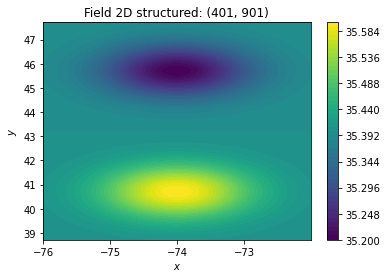

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstools as gs

# Datos de calidad del aire
data = {
    'lat': [40.7128, 40.7138, 40.7148, 40.7158, 39.5],
    'lon': [-74.0060, -74.0070, -74.0080, -74.0090, -74.0100],
    'quality': [65, 55, 24, 65, 70]
}

df = pd.DataFrame(data)
coordinates = df[['lon', 'lat']].values
values = df['quality'].values


data = {
    'Sensor': ["S1", "S2", "S3", "S4", "S5"],
    'lat': [40.7128, 40.7138, 40.7148, 40.7158, 39.5],
    'lon': [-74.0060, -74.0070, -74.0080, -74.0090, -74.0100],
    'DQIndex': [65, 55, 24, 65, 70]
}

interpolation_point = {
    'lat': [40.6504],
    'lon': [-74.0038]
}

'''
# Crear el modelo de variograma (modelo esférico o gaussiano)
model = gs.Exponential(dim=2, var=0.5, len_scale=1)  # Ajusta la longitud de escala si es necesario

# Configurar el Kriging ordinario
krige = gs.krige.Ordinary(model, coordinates, values)
cond_srf = gs.CondSRF(krige)

# Definir la cuadrícula para la predicción
lon_min, lon_max = coordinates[:, 0].min() - 0.005, coordinates[:, 0].max() + 0.005
lat_min, lat_max = coordinates[:, 1].min() - 0.005, coordinates[:, 1].max() + 0.005

grid_lon, grid_lat = np.meshgrid(np.linspace(lon_min, lon_max, 10),
                                 np.linspace(lat_min, lat_max, 10))
grid_pos = np.c_[grid_lon.ravel(), grid_lat.ravel()]

cond_srf.set_pos(grid_pos)

# Generar una única realización del campo aleatorio condicionado
seed = gs.random.MasterRNG(20240731)
field = cond_srf(seed=seed(), store="field_0")

# Visualización
plt.figure(figsize=(12, 8))

# Mostrar el campo aleatorio condicionado
contour = plt.contourf(grid_lon, grid_lat, field.reshape(grid_lon.shape), cmap='viridis', levels=20, alpha=0.8)
plt.colorbar(contour, label='Calidad del Aire')

# Mostrar los puntos de datos originales
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', cmap='viridis', marker='o', s=100, label='Datos Reales')

# Etiquetas y título
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Campo Aleatorio Condicionado usando Kriging')
plt.legend()
plt.grid(True)

# Verificar los límites del gráfico
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.show()



# Verificación de los datos generados
print("Datos Generados:")
print("Posiciones de la cuadrícula:")
print(grid_pos[:10])  # Mostrar solo los primeros 10 puntos para claridad
print("Valores del campo:")
print(field[:10])  # Mostrar solo los primeros 10 valores para claridad


'''
data = {
    'lat': [40.7128, 45.7138],
    'lon': [-74.0060, -74.0070],
    'quality': [35.6, 35.2]
}

cov_model = gs.Gaussian(dim=2)
krige = gs.krige.Ordinary(cov_model, [np.array(data['lon']), np.array(data['lat'])], np.array(data['quality']))
gridx = np.arange(min(data['lon']) - 2, max(data['lon']) + 2, 0.01)
gridy = np.arange(min(data['lat']) - 2, max(data['lat']) + 2, 0.01)
krige.structured([gridx, gridy])
krige.plot()

https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_05_kriging.html

In [61]:
krige

Ordinary(model=Gaussian, cond_no=5)

In [34]:
field.reshape(grid_lon.shape)

array([[59.76600026, 60.67471875, 59.76209283, 60.67471875, 59.75655758,
        60.67471875, 59.74939269, 60.67471875, 59.74060008, 60.67471875],
       [59.7301854 , 60.67471875, 59.71815792, 60.67471875, 59.70453052,
        60.67471875, 59.68931961, 60.67471875, 59.67254504, 60.67471875],
       [59.76600026, 60.66003781, 59.76209283, 60.66003781, 59.75655758,
        60.66003781, 59.74939269, 60.66003781, 59.74060008, 60.66003781],
       [59.7301854 , 60.66003781, 59.71815792, 60.66003781, 59.70453052,
        60.66003781, 59.68931961, 60.66003781, 59.67254504, 60.66003781],
       [59.76600026, 60.64432438, 59.76209283, 60.64432438, 59.75655758,
        60.64432438, 59.74939269, 60.64432438, 59.74060008, 60.64432438],
       [59.7301854 , 60.64432438, 59.71815792, 60.64432438, 59.70453052,
        60.64432438, 59.68931961, 60.64432438, 59.67254504, 60.64432438],
       [59.76600026, 60.6276089 , 59.76209283, 60.6276089 , 59.75655758,
        60.6276089 , 59.74939269, 60.6276089 

In [35]:
grid_lon, grid_lat,

(array([[-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.0055    ],
        [-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.0055    ],
        [-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.0055    ],
        [-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.0055    ],
        [-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.0055    ],
        [-74.0105    , -74.00994444, -74.00938889, -74.00883333,
         -74.00827778, -74.00772222, -74.00716667, -74.00661111,
         -74.00605556, -74.005

c:\Users\Fernando Avila\anaconda3\lib\site-packages\gstools\field\plot.py:401: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Field 2D structured: (55, 65)'}, xlabel='$x$', ylabel='$y$'>

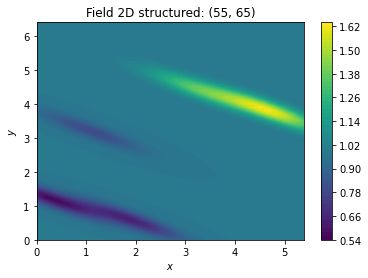

In [40]:
import numpy as np
from gstools import Gaussian, krige
#from pykrige.ok import OrdinaryKriging
from matplotlib import pyplot as plt

# conditioning data
data = np.array([[0.3, 1.2, 0.47],
                 [1.9, 0.6, 0.56],
                 [1.1, 3.2, 0.74],
                 [3.3, 4.4, 1.47],
                 [4.7, 3.8, 1.74]])
# grid definition for output field
gridx = np.arange(0.0, 5.5, 0.1)
gridy = np.arange(0.0, 6.5, 0.1)
# a GSTools based covariance model
cov_model = Gaussian(dim=2, len_scale=1, anis=.2, angles=-.5, var=.5, nugget=.1)
# ordinary kriging with pykrige
#OK1 = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], cov_model)
#z1, ss1 = OK1.execute('grid', gridx, gridy)
#plt.imshow(z1, origin="lower")
#plt.show()
# ordinary kriging with gstools for comparison
OK2 = krige.Ordinary(cov_model, [data[:, 0], data[:, 1]], data[:, 2])
OK2.structured([gridx, gridy])
OK2.plot()

In [47]:
data = {
    'lat': [40.7128, 40.7138, 40.7148, 40.7158, 40.7168],
    'lon': [-74.0060, -74.0070, -74.0080, -74.0090, -74.0100],
    'quality': [50, 55, 60, 65, 70]
}

np.array(data['lat'])

array([40.7128, 40.7138, 40.7148, 40.7158, 40.7168])

### EXPLORACIÓN DE KRIGING  

In [496]:
## FUNCIONES PARA EL CÁLCULO DE KRIGING

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
from scipy.stats import linregress
from scipy.linalg import solve, det, inv
import random
import warnings
import math

import funciones_FS as f_FS
import funciones_TS as f_TS
import funciones_OC as f_OC
import funciones_DF as f_DF
import importlib



# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

def draw_map(sensors_df, interpolation_df):
    """
    Dibuja el mapa con la posición de los sensores
    Ingresa los dataframe con los nombres de los sesnores y las coordenadas de longitud y latitud de 
    cada sensor
    """
    #interpolation_df ["Sensor"] = "INT"
    coor_siata = interpolation_df.groupby(['Sensor'])[['lat', 'lon']].mean()
    coor = sensors_df.groupby(['Sensor'])[['lat', 'lon']].mean()

    all_coor = pd.concat([coor_siata, coor])
    #result = coor.join(f_DQM.accuracy2(datos_SIATA[['pm25']], fusion), how="inner")

    ruta = "E:/"
    mapa = gpd.read_file(ruta+'Colombia/Antioquia/Politico/').to_crs(epsg=4326)

    mapa['centroid'] = mapa.centroid

    gdf = gpd.GeoDataFrame(coor, geometry=gpd.points_from_xy(coor.lon, coor.lat)) # Todos los nodos de CS
    #gdf = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result.longitud, result.latitud)) # Solo los nodos cd CS cercanos al nodo SIATA seleccionado
    gdf_siata = gpd.GeoDataFrame(coor_siata, geometry=gpd.points_from_xy(coor_siata.lon, coor_siata.lat))

    fig, ax = plt.subplots()
    # Añade recuadro 1
    axins = ax.inset_axes([0.5, 0.25, 0.45, 0.45])

    # Gráfica recuadro 1
    mapa.query('SUBREGION=="AMVA"').plot(ax=axins, color='white', edgecolor='black')

    # limita área a mostrar recuadro 1
    ampl = 0.005  # Valor para amplizar el zoom en el mapa más allá de los maximos y minimos de las coordenadas
    axins.set(ylabel='', xlabel='', xlim=(min(all_coor['lon'])-ampl, max(all_coor['lon'])+ampl), ylim=(min(all_coor['lat'])-ampl, max(all_coor['lat'])+ampl), xticks=[], yticks=[])
    axins.set_title('Citizen Scientist nodes', y=-0.01)

    mapa.query('SUBREGION=="AMVA"').plot(ax=ax, color='white', edgecolor='black')
    mapa.query('SUBREGION=="AMVA"').apply(lambda x: ax.annotate(text=x['MPIO_CNMBR'], 
                                                                xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), 
                                                                ha='center'), axis=1)
    fig.set_size_inches(10, 10)
    gdf.apply(lambda x: axins.annotate(text=x.name, xy=(x['lon'],x['lat']), ha='center'), axis=1)
    
    gdf.plot(ax=axins, color='red')
    gdf_siata.apply(lambda x: axins.annotate(text=x.name, xy=(x['lon']+0.003,x['lat']), ha='center'), axis=1)
    gdf_siata.plot(ax=axins, color='blue')

    gdf.plot(ax=ax, color='red')
    gdf_siata.plot(ax=ax, color='blue', marker='*', markersize=100)
    ax.indicate_inset_zoom(axins)
    #plt.savefig("map-all-nodes.eps", dpi=200, bbox_inches='tight')
    plt.show()

def semivariances(values, distances):
    """
    Calcula la semivarianza de las distancias
    Ingresa la matriz de distancias y los valores
    Retorna un dataframe con las disntancias y los valores de las semivarianzas
    """

    if len(values) <= 1:
        semiva = pd.DataFrame([[0,0],[1,1]], columns=["distances", "semivariances"])
    else:
        semiva = pd.DataFrame(columns=["distances", "semivariances"])
        row=0
        for i in range(len(values)):
            for j in range(i+1, len(values)):
                semiva.loc[row] = [distances[i,j], ((values[i] - values[j])**2)/2]
                row += 1

        semiva.sort_values(by=["distances"], inplace=True)

    return semiva  


def calculate_distances(data, interp_point):
    """
    Calcula la distancia entre dos puntos utilizando los valores de latitud y longitud y teniendo 
    en cuenta la curvatura de la tierra
    Ingresa el dataframe con las coordenadas de longitud y latitud de cada uno de los sensores
    y el dataframe con las coordenadas del punto de interpolación
    Devuelve un vetor con las distancias entre el sensor y el punto de interpolación y una matriz 
    con las distancias entre los sensores (En Km)
    El orden de los valores en la lista es el orden de los sensores en el dataframe

    #lon1 = Longitud punto 1
    #lat1 = Latitud punto 1
    #lon2 = Longitud punto 2
    #lat2 = Latitud punto 2
    # Retorma la distancia en Kms
    """
    # Radio de la tierra
    R = 6378 

    num_sensors = len(data)
    distance_matrix = np.zeros((num_sensors, num_sensors)) 
    
    for i in range(num_sensors):
        for j in range(num_sensors):
            #Convertir grados decimales en radianes
            lon1, lat1, lon2, lat2 = map(math.radians, [data['lon'][i], data['lat'][i], data['lon'][j], data['lat'][j]])
            
            #Formula
            dlon = lon2 - lon1 #Distancia entre longitudes
            dlat = lat2 - lat1 #Distancia entre latitudes
            a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2 
            c = 2 * math.asin(math.sqrt(a))
            distance_matrix[i, j] = c * R
    

    distances = np.array([])
    for i in range(num_sensors):
        #Convertir grados decimales en radianes
        lon1, lat1, lon2, lat2 = map(math.radians, [data['lon'][i], data['lat'][i], interp_point['lon'][0], interp_point['lat'][0]])
        
        #Formula
        dlon = lon2 - lon1 #Distancia entre longitudes
        dlat = lat2 - lat1 #Distancia entre latitudes
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2 
        c = 2 * math.asin(math.sqrt(a))
        distances = np.append(distances, c * R)

    return distances, distance_matrix

def covariance_matrix(values, distances, DQIndex, distances_interp, model="LI"):
    """
    Construye la matriz de covarianzas con base en las distancias y el modelo elegido
    Ingresa la matriz de distancias y el tipo de modelo de variograma que se quiere usar: 
    Inverso a la distancia (ID),
    Exponencial (EX), 
    Esférico (ES),
    Lineal (LI),
    Gaussiano (GS),
    Logarítmico (LG)
    Devuelve la matriz de covarianzas"""

    semiva = semivariances(values, distances)
    num_sensors = len(values)
    covariance_C = np.ones((num_sensors+1, num_sensors+1))
    covariance_b = np.ones(num_sensors+1)

    # c0 = Nugget, que es la semivarianza en el la distancia = 0, o en la distancia mínima (error de medición)
    # c = sill, que es la semivarianza de la distancia máxima
    # a es el rango o alcance/distancia  en el que se alcanza el valor del sill 
    index = semiva[semiva['semivariances'] == max(semiva["semivariances"])].index[0]
    c0 = min(semiva["semivariances"])
    c = semiva.iloc[index]['semivariances']
    a = semiva.iloc[index]['distances']
    #print(f"c={c}, c0={c0}, a={a}")
        
    if model == "LI":
        if len(semiva) > 1:
            # Realizar la regresión lineal
            # c0 = Nugget, c = sill
            # c0 será el intercepto y c será la pendiente.
            c, c0, r_value, p_value, std_err = linregress(np.array(semiva["distances"]), np.array(semiva["semivariances"]))

            for i in range(num_sensors):
                for j in range(num_sensors):
                    covariance_C[i, j] = c0 + (c*distances[i, j])
            covariance_C[i+1, j+1] = 0

            for i in range(num_sensors):
                covariance_b[i] = c0 + (c*distances_interp[i])
        else:
            print("There is not enough values for the linear model")
            
    elif model == "EX":

        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c*(1-np.exp(-(3*distances[i, j])/a))
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c*(1-np.exp(-distances_interp[i]/a))  
    
    elif model == "GS":

        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c*(1-np.exp(-((distances[i, j]/a)**2)))
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c*(1-np.exp(-((distances_interp[i]/a)**2)))

    elif model == "ID":      

        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c/(distances[i, j] + 1)
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c/(distances_interp[i] + 1)

    elif model == "ES":

        for i in range(num_sensors):
            for j in range(num_sensors):
                if distances[i, j] > a:
                    covariance_C[i, j] = c0 + c
                else:
                    covariance_C[i, j] = c0 + c*(((3*distances[i, j])/(2*a)) - ((distances[i, j]**3)/(2*(a**3))))
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            if distances[i, j] > a:
                covariance_b[i] = c0 + c
            else:
                covariance_b[i] = c0 + c*(((3*distances_interp[i])/(2*a)) - ((distances_interp[i]**3)/(2*(a**3))))
               
    elif model == "LG":

        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c*np.log(distances[i, j] + 1)
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c*np.log(distances_interp[i] + 1)
    
    elif model == "PP_lineal":
        # a es el parámetro de ajuste del QQ Index
        # b es el parámetro de ajuste de la distancia
        #distances_interp = distances_interp/distances_interp.max()
        #distances = distances/distances.max()
        c, c0, r_value, p_value, std_err = linregress(np.array(semiva["distances"]), np.array(semiva["semivariances"]))

        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c*((a*(1-np.mean([DQIndex[i],DQIndex[j]]))+distances[i, j])/(2*a))
                #covariance_C[i, j] = c0 + c*((1 + (distances[i, j]**adj[1])) / (1 + np.mean([DQIndex[i],DQIndex[j]])**adj[0]))
                #covariance_C[i, j] = c0 + c*((1 + np.mean([DQIndex[i],DQIndex[j]])**adj[0]) /  (1 + (distances[i, j]**adj[1])))
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c*((a*(1-DQIndex[i])+distances_interp[i])/(2*a))
            #covariance_b[i] = c0 + c*((1 + (distances_interp[i]**adj[1])) / (1 + (DQIndex[i]**adj[0])))
            #covariance_b[i] = c0 + c*((1 + (DQIndex[i]**adj[0])) /  (1 + (distances_interp[i]**adj[1])))

    elif model == "PP_expo":
        
        for i in range(num_sensors):
            for j in range(num_sensors):
                covariance_C[i, j] = c0 + c*(((np.mean([DQIndex[i],DQIndex[j]]) - 1)**2 + (distances[i, j]/a)**2)/2)
        covariance_C[i+1, j+1] = 0

        for i in range(num_sensors):
            covariance_b[i] = c0 + c*(((DQIndex[i] - 1)**2 + (distances_interp[i]/a)**2)/2)
 
    return covariance_C, covariance_b, (c0,c,a)

def experim(values, DQIndex, distances_interp):

    num_sensors = len(values)
    a = max(distances_interp)

    val = []
    for i in range(num_sensors):
        val.append(1-(((DQIndex[i] - 1)**2 + (distances_interp[i]/a)**2)/2))
    
    return np.array(val)/np.sum(val)

def lineal_experim(values, DQIndex, distances_interp):

    num_sensors = len(values)
    a = max(distances_interp)

    val = []
    for i in range(num_sensors):
        val.append(1-((a*(1-DQIndex[i])+distances_interp[i])/(2*a)))
    
    return np.array(val)/np.sum(val)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


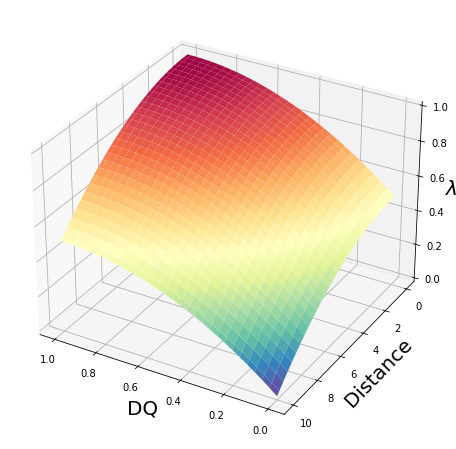

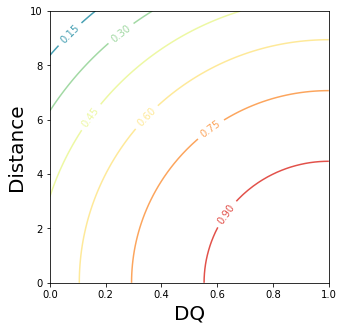

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(20,10))
#ax = fig.add_subplot(111, projection='3d')

a = 10
p = 3
x = np.linspace(0,1,60)
y = np.linspace(0,a,60)

xx, yy = np.meshgrid(x,y)

z = ((xx-2)**2 + (yy+2)**2 -np.exp(((xx-2)-(yy+2))/2)) # Ecuación base, NO MODIFICAR X=(-2,2), Y=(-2,2)
#z = (p*xx-p)**2 + ((p*yy/a))**2 -np.exp(((p*xx-p)-((p*yy/a)))/2)
# z= ((xx - 1)**2 + (yy/a)**2)/2
z= 1-(((xx - 1)**2 + (yy/a)**2)/2)  # Modelo exponencial elegido
#z = 1- (a*(1-xx)+yy)/(2*a)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection = '3d')
ax.plot_surface(xx, yy, z, cmap="Spectral_r")
ax.view_init(30, 120)

ax.set_xlabel('DQ', fontsize=20)      # <====== This works
ax.set_ylabel('Distance', fontsize=20) # <====== This doesn't work
ax.zaxis.labelpad=-0.7
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\lambda$', rotation=0, fontsize=20) # <====== This doesn't work
plt.savefig("suf-propuesta.eps", dpi=200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(1,1,1)
CS = ax2.contour(xx, yy, z, cmap='Spectral_r')
ax2.clabel(CS, inline=True, fontsize=10)
ax2.set_xlabel('DQ', fontsize=20)      # <====== This works
ax2.set_ylabel('Distance', fontsize=20) # <====== This doesn't work
#ax2.set_zlabel('Incertidumbre') # <====== This doesn't work
plt.savefig("cont-propuesta.eps", dpi=200, bbox_inches='tight')
plt.show()

#ax1 = fig.add_subplot(1,3,3, projection = '3d')
#ax1.contour(xx, yy, z, cmap='Spectral_r')
#ax1.view_init(30, 1200)
#ax1.set_xlabel('DQ')      # <====== This works
#ax1.set_ylabel('Distance') # <====== This doesn't work
#ax1.set_zlabel('Incertidumbre') # <====== This doesn't work


#plt.savefig("suf-propuesta.eps", dpi=200, bbox_inches='tight')

In [135]:
import pandas as pd
import numpy as np
import importlib
import DQM as f_DQM
import funciones_FS as f_FS
ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/Datos/"
df_CS = pd.read_csv(ruta+"datosCoordenados_CS.csv",sep=",")
df_SIATA = pd.read_csv(ruta+"datosCoordenados_SIATA.csv",sep=",")
DQIndex_x_H = pd.read_csv(ruta+"DQIndex_x_H.csv",sep=",")
DQIndexCS = pd.read_csv(ruta+"DQIndex.csv",sep=",")
DQIndexCS.set_index("index", inplace=True)

In [3]:
importlib.reload(f_FS)
fusion, nodosCS = f_FS.extrac_data_CS(df_CS, df_SIATA, 50, 80, '2020', '02', ['01', '28'])
datos_h = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)


NameError: name 'importlib' is not defined

In [1582]:
fechas = {}
for fecha in datos_h.index.unique():
    #print(fecha)
    if datos_h.loc[fecha].codigoSerial.size == 1:
        fechas[str(fecha)] = [datos_h.loc[fecha].codigoSerial]
        continue
    fechas[str(fecha)] = list(datos_h.loc[fecha].codigoSerial)

dupli = list(range(1,300))
for d in fechas.keys():
    print(d, len(fechas[d]))
    #print(set(dupli) & set(fechas[d]))





2020-02-01 00:00:00 146
2020-02-01 01:00:00 146
2020-02-01 02:00:00 146
2020-02-01 03:00:00 146
2020-02-01 04:00:00 146
2020-02-01 05:00:00 146
2020-02-01 06:00:00 146
2020-02-01 07:00:00 146
2020-02-01 08:00:00 146
2020-02-01 09:00:00 147
2020-02-01 10:00:00 147
2020-02-01 11:00:00 147
2020-02-01 12:00:00 147
2020-02-01 13:00:00 147
2020-02-01 14:00:00 145
2020-02-01 15:00:00 144
2020-02-01 16:00:00 145
2020-02-01 17:00:00 144
2020-02-01 18:00:00 143
2020-02-01 19:00:00 144
2020-02-01 20:00:00 144
2020-02-01 21:00:00 144
2020-02-01 22:00:00 144
2020-02-01 23:00:00 142
2020-02-02 00:00:00 146
2020-02-02 01:00:00 146
2020-02-02 02:00:00 147
2020-02-02 03:00:00 148
2020-02-02 04:00:00 148
2020-02-02 05:00:00 148
2020-02-02 06:00:00 148
2020-02-02 07:00:00 148
2020-02-02 08:00:00 148
2020-02-02 09:00:00 148
2020-02-02 10:00:00 149
2020-02-02 11:00:00 149
2020-02-02 12:00:00 147
2020-02-02 13:00:00 148
2020-02-02 14:00:00 147
2020-02-02 15:00:00 146
2020-02-02 16:00:00 147
2020-02-02 17:00

In [1603]:
datos_SIATA = df_SIATA.copy()
datos_SIATA['fechaHora'] = pd.to_datetime(datos_SIATA['fechaHora'])
datos_SIATA = datos_SIATA.set_index('fechaHora').loc['2020-02']

fechas = {}
for fecha in datos_SIATA.index.unique():
    #print(fecha)
    if datos_SIATA.loc[fecha].codigoSerial.size == 1:
        fechas[str(fecha)] = [datos_SIATA.loc[fecha].codigoSerial]
        continue
    fechas[str(fecha)] = list(datos_SIATA.loc[fecha].codigoSerial)

dupli = list(range(1,300))
for d in fechas.keys():
    print(d, len(fechas[d]))

2020-02-01 00:00:00 20
2020-02-01 01:00:00 20
2020-02-01 10:00:00 20
2020-02-01 11:00:00 20
2020-02-01 12:00:00 20
2020-02-01 13:00:00 20
2020-02-01 14:00:00 20
2020-02-01 15:00:00 20
2020-02-01 16:00:00 20
2020-02-01 17:00:00 20
2020-02-01 18:00:00 20
2020-02-01 19:00:00 20
2020-02-01 02:00:00 20
2020-02-01 20:00:00 20
2020-02-01 21:00:00 20
2020-02-01 22:00:00 20
2020-02-01 23:00:00 20
2020-02-01 03:00:00 20
2020-02-01 04:00:00 20
2020-02-01 05:00:00 20
2020-02-01 06:00:00 20
2020-02-01 07:00:00 20
2020-02-01 08:00:00 20
2020-02-01 09:00:00 20
2020-02-02 00:00:00 20
2020-02-02 01:00:00 20
2020-02-02 10:00:00 20
2020-02-02 11:00:00 20
2020-02-02 12:00:00 20
2020-02-02 13:00:00 20
2020-02-02 14:00:00 20
2020-02-02 15:00:00 20
2020-02-02 16:00:00 20
2020-02-02 17:00:00 20
2020-02-02 18:00:00 20
2020-02-02 19:00:00 20
2020-02-02 02:00:00 20
2020-02-02 20:00:00 20
2020-02-02 21:00:00 20
2020-02-02 22:00:00 20
2020-02-02 23:00:00 20
2020-02-02 03:00:00 20
2020-02-02 04:00:00 20
2020-02-02 


Estacion SIATA: 12 | Cantidad de nodos disponibles: 6 | Valor SIATA: 25.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
74      0.63  1.44   8.15  0.02  0.04  0.12  0.05 -0.28  0.03
77      0.76  0.32  22.10  0.63  0.42  0.58  0.54 -0.28  0.59
117     0.56  0.69  10.72  0.17  0.15  0.07  0.14  1.30  0.16
119     0.58  0.72  11.74  0.00  0.14 -0.00  0.05 -0.28  0.02
120     0.66  1.05   9.04 -0.02  0.06  0.10  0.03 -0.28  0.00
169     0.62  0.64  15.24  0.20  0.18  0.14  0.19  0.83  0.20

Estacion SIATA: 28 | Cantidad de nodos disponibles: 5 | Valor SIATA: 37.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
111     0.65  0.81  11.76  0.22  0.22  0.26  0.20  0.29  0.21
157     0.66  0.86  11.55  0.16  0.20  0.19  0.15  0.27  0.16
213     0.66  1.23  12.39 -0.01  0.07 -0.13  0.04  0.14  0.01
215     0.60  0.33  12.03  0.64  0.48  0.77 

,12,28,31,38,48,69,78,79,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,
LI,0.39,0.68,0.51,0.20,0.70,0.10,0.24,0.78,0.65,0.56,0.66,0.67,6.58,0.63,0.67
EX,0.65,0.68,0.82,0.19,0.71,0.09,0.68,0.70,0.35,0.51,0.66,0.55,0.66,0.73,0.63
GS,0.60,0.68,0.48,0.03,0.72,0.11,0.06,0.55,0.62,0.42,0.72,0.52,1.78,0.75,0.66
ID,0.57,0.68,1.07,0.19,0.70,0.28,1.02,0.68,0.84,0.54,0.67,0.56,1.09,0.81,0.64
ES,1.32,0.68,1.35,0.17,2.51,0.29,0.86,1.11,0.57,0.49,0.66,0.56,1.24,0.85,0.65
LG,0.42,0.68,0.78,0.17,0.70,0.11,0.81,0.68,0.56,0.52,0.66,0.57,1.14,0.88,0.65


12,28,31,38,48,69,78,79,82,83,84,86,87,88,90
LI,ID,GS,GS,LI,EX,GS,GS,EX,GS,LI,GS,EX,LI,EX
LG,LG,LI,LG,LG,LI,LI,ID,LG,ES,EX,EX,ID,EX,ID
ID,EX,LG,ES,ID,GS,EX,LG,ES,EX,LG,ID,LG,GS,LG
GS,LI,EX,ID,EX,LG,LG,EX,GS,LG,ES,ES,ES,ID,ES
EX,GS,ID,EX,GS,ID,ES,LI,LI,ID,ID,LG,GS,ES,GS
ES,ES,ES,LI,ES,ES,ID,ES,ID,LI,GS,LI,LI,LG,LI


,LI,EX,GS,ID,ES,LG
1,4,4,6,1,0,0
2,3,3,0,3,1,5
3,0,3,2,3,2,5
4,1,3,2,2,4,3
5,2,2,4,4,2,1
6,5,0,1,2,6,1


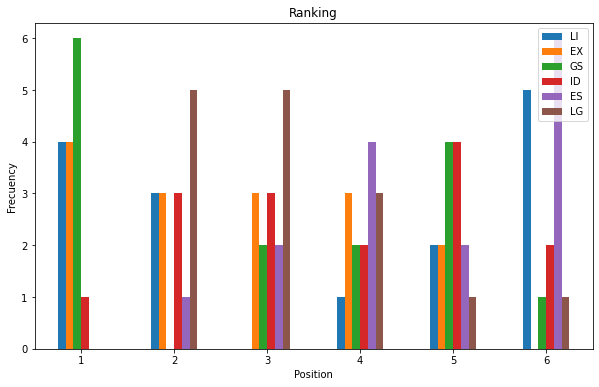

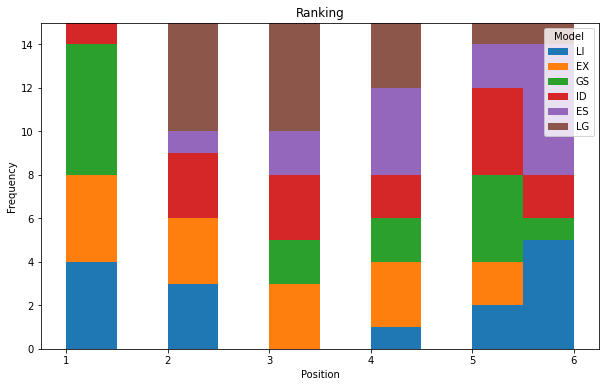

,LI,EX,GS,ID,ES,LG
1,4.0,4.0,6.0,1,0.0,0.0
2,3.0,3.0,0.0,3,1.0,5.0
3,0.0,3.0,2.0,3,2.0,5.0
4,1.0,3.0,2.0,2,4.0,3.0
5,2.0,2.0,4.0,4,2.0,1.0
6,5.0,0.0,1.0,2,6.0,1.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 5 | Valor SIATA: 73.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
74      0.78  1.44  75.40 -0.03  0.03  0.00  0.02 -0.02 -0.01
77      0.75  0.32  87.02  0.65  0.40  1.12  0.55  0.67  0.61
119     0.77  0.72  77.80 -0.01  0.11 -0.40  0.03 -0.05  0.00
160     0.64  0.82  48.45  0.09  0.16  0.07  0.11  0.10  0.10
169     0.72  0.64  91.22  0.31  0.29  0.21  0.28  0.30  0.30

Estacion SIATA: 25 | Cantidad de nodos disponibles: 11 | Valor SIATA: 63.0
          DQ  Dist    Val
Sensor                   
4       0.78  1.36  72.08
115     0.73  1.30  60.15
124     0.69  0.99  90.02
168     0.81  1.37  62.19
169     0.69  1.30  91.22
259     0.43  1.37  68.77
261     0.51  1.37   9.26
262     0.45  1.37  28.11
265     0.79  1.37  60.31
266     0.77  1.37  43.78
267     0.70  1.37  22.34

Estacion SIATA: 28 | Cantidad de nodos disponibles: 4 | Valor SIATA: 45.0
  

,12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,
LI,1.30,17.39,1.58,37.13,0.65,0.77,5.82,10.15,1.46,0.64,0.49,1.01,5.34,3.09,1.04,1.45
EX,0.58,36.12,1.27,3.86,0.73,0.72,2.44,2.55,0.85,1.10,2.04,1.31,0.47,0.18,1.97,0.69
GS,0.25,22.00,1.06,2.71,0.38,0.74,1.64,2.67,0.50,0.39,1.32,0.18,0.32,0.45,0.66,0.41
ID,1.31,34.15,1.46,4.23,0.99,0.85,3.06,1.88,0.97,4.10,1.76,2.19,0.44,0.24,2.08,0.58
ES,0.79,59.54,1.34,4.61,1.04,0.37,3.00,2.36,0.83,0.87,1.56,1.72,0.65,0.24,2.54,0.48
LG,0.79,44.05,1.25,3.41,0.92,0.74,2.26,2.18,0.78,0.54,1.75,1.91,0.48,0.21,2.34,0.53


12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
GS,LI,GS,GS,GS,ES,GS,ID,GS,GS,LI,GS,GS,EX,GS,GS
EX,GS,LG,LG,LI,EX,LG,LG,LG,LG,GS,LI,ID,LG,LI,ES
LG,ID,EX,EX,EX,GS,EX,ES,ES,LI,ES,EX,EX,ES,EX,LG
ES,EX,ES,ID,LG,LG,ES,EX,EX,ES,LG,ES,LG,ID,ID,ID
LI,LG,ID,ES,ID,LI,ID,GS,ID,EX,ID,LG,ES,GS,LG,EX
ID,ES,LI,LI,ES,ID,LI,LI,LI,ID,EX,ID,LI,LI,ES,LI


,LI,EX,GS,ID,ES,LG
1,2,1,11,1,1,0
2,3,2,2,1,1,7
3,1,7,1,1,4,2
4,0,3,0,4,5,4
5,2,2,2,5,2,3
6,8,1,0,4,3,0


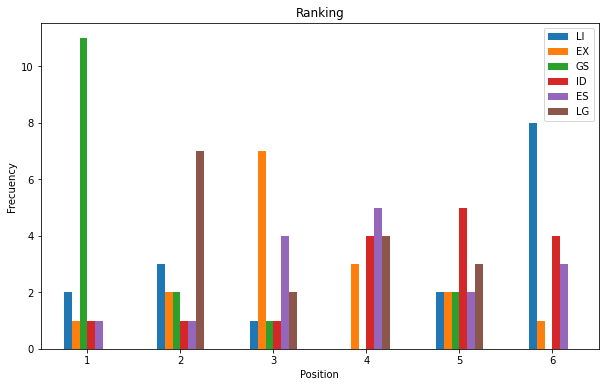

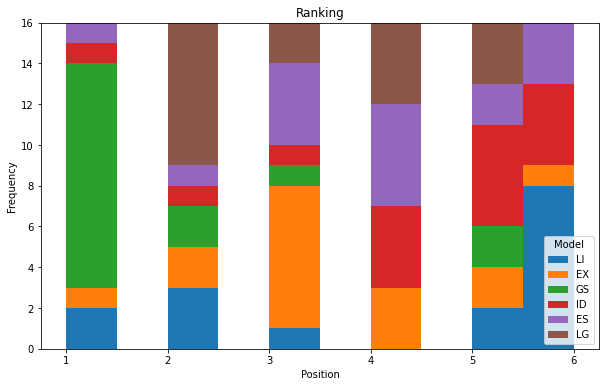

,LI,EX,GS,ID,ES,LG
1,6.0,5.0,17.0,2,1.0,0.0
2,6.0,5.0,2.0,4,2.0,12.0
3,1.0,10.0,3.0,4,6.0,7.0
4,1.0,6.0,2.0,6,9.0,7.0
5,4.0,4.0,6.0,9,4.0,4.0
6,13.0,1.0,1.0,6,9.0,1.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 5 | Valor SIATA: 17.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
74      0.70  1.44  15.45 -0.03  0.01 -0.08  0.02  0.00 -0.01
77      0.64  0.32  28.87  0.62  0.46  0.72  0.55  0.63  0.59
120     0.80  1.05  17.23  0.07  0.11 -0.02  0.09  0.01  0.07
160     0.73  0.82  11.76  0.09  0.17  0.05  0.11  0.08  0.10
169     0.61  0.64  20.59  0.25  0.26  0.34  0.24  0.28  0.25

Estacion SIATA: 25 | Cantidad de nodos disponibles: 12 | Valor SIATA: 14.0
          DQ  Dist    Val
Sensor                   
4       0.74  1.36  18.30
115     0.67  1.30  22.22
120     0.76  0.63  17.23
124     0.70  0.99  18.55
168     0.75  1.37  15.76
169     0.56  1.30  20.59
259     0.07  1.37  25.58
261     0.61  1.37   9.26
262     0.65  1.37  12.87
265     0.69  1.37  19.86
266     0.76  1.37  16.15
267     0.71  1.37  10.83

Estacion SIATA: 28 | Cantidad de nodos disponibles

,12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,
LI,1.14,1.29,0.11,0.26,0.41,0.10,0.73,1.39,2.23,0.85,17.99,1.62,2.39,0.96,0.61,0.95
EX,2.12,1.47,0.23,0.11,1.01,0.09,0.55,1.00,2.29,1.87,1.12,2.91,7.05,1.45,0.54,0.87
GS,0.88,1.15,0.14,0.03,0.14,0.10,0.54,1.53,2.09,0.35,7.57,2.01,5.09,1.07,0.96,0.54
ID,3.96,1.54,0.28,0.10,1.85,0.11,0.58,1.02,2.28,6.55,1.05,3.42,6.65,1.71,0.55,0.91
ES,3.05,2.68,0.34,0.25,1.27,0.01,0.44,1.73,2.24,1.15,1.04,4.45,11.07,2.04,0.54,0.79
LG,2.49,1.77,0.35,0.07,1.67,0.10,0.57,1.04,2.25,0.70,1.07,3.01,8.37,2.19,0.55,0.80


12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
GS,GS,LI,GS,GS,ES,ES,EX,GS,GS,ES,LI,LI,LI,ES,GS
LI,LI,GS,LG,LI,EX,GS,ID,LI,LG,ID,GS,GS,GS,EX,ES
EX,EX,EX,ID,EX,GS,EX,LG,ES,LI,LG,EX,ID,EX,LG,LG
LG,ID,ID,EX,ES,LG,LG,LI,LG,ES,EX,LG,EX,ID,ID,EX
ES,LG,ES,ES,LG,LI,ID,GS,ID,EX,GS,ID,LG,ES,LI,ID
ID,ES,LG,LI,ID,ID,LI,ES,EX,ID,LI,ES,ES,LG,GS,LI


,LI,EX,GS,ID,ES,LG
1,4,1,7,0,4,0
2,4,2,5,2,1,2
3,1,7,1,2,1,4
4,1,4,0,4,2,5
5,2,1,2,4,4,3
6,4,1,1,4,4,2


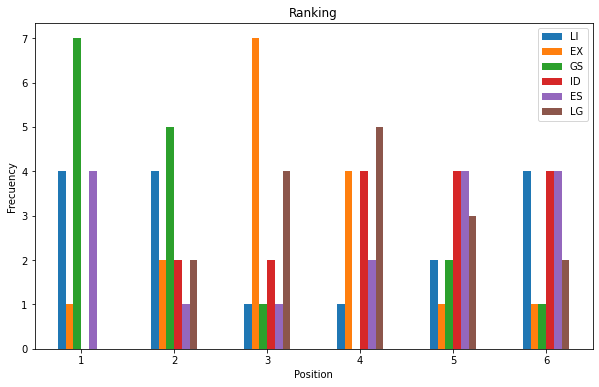

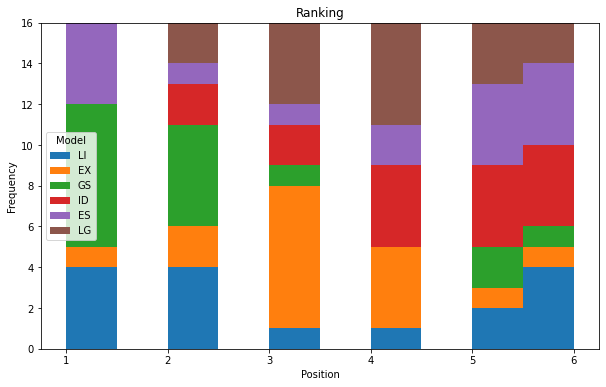

,LI,EX,GS,ID,ES,LG
1,10.0,6.0,24.0,2.0,5.0,0.0
2,10.0,7.0,7.0,6.0,3.0,14.0
3,2.0,17.0,4.0,6.0,7.0,11.0
4,2.0,10.0,2.0,10.0,11.0,12.0
5,6.0,5.0,8.0,13.0,8.0,7.0
6,17.0,2.0,2.0,10.0,13.0,3.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 6 | Valor SIATA: 45.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
74      0.62  1.44  48.74 -0.03 -0.03 -0.00  0.01  0.14 -0.01
77      0.76  0.32  46.83  0.63  0.45  1.05  0.54  0.11  0.59
119     0.80  0.72  44.82 -0.01  0.13 -0.40  0.03  0.11  0.00
120     0.76  1.05  34.12  0.07  0.07 -0.02  0.09  0.30  0.07
160     0.73  0.82  28.84  0.10  0.15  0.08  0.10  0.14  0.10
169     0.78  0.64  44.59  0.25  0.25  0.29  0.23  0.19  0.25

Estacion SIATA: 25 | Cantidad de nodos disponibles: 12 | Valor SIATA: 26.0
          DQ  Dist    Val
Sensor                   
4       0.77  1.36  31.34
115     0.75  1.30  32.54
120     0.75  0.63  34.12
124     0.74  0.99  29.46
168     0.78  1.37  29.02
169     0.65  1.30  44.59
174     0.14  1.37  10.39
261     0.57  1.37   9.26
262     0.72  1.37  19.42
265     0.66  1.37  42.54
266     0.79  1.37  24.29
267     0.69  1

,12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,
LI,0.26,3.11,0.18,0.83,0.10,0.31,0.44,0.08,0.27,0.64,0.16,0.18,2.46,0.11,0.23,0.15
EX,1.40,3.73,0.28,0.35,0.08,0.34,0.45,0.06,0.42,0.71,0.41,0.10,0.19,0.03,3.73,0.18
GS,0.31,0.57,0.12,0.18,0.04,0.31,0.35,0.07,0.11,0.40,0.27,0.10,0.24,0.12,1.57,0.04
ID,1.94,6.25,0.39,0.40,0.10,0.52,0.51,0.06,1.05,1.13,0.43,0.08,0.18,0.06,4.11,0.15
ES,2.77,5.42,0.52,0.47,0.07,0.40,0.51,0.04,0.49,0.52,0.69,0.16,0.20,0.06,6.20,0.12
LG,1.13,4.05,0.25,0.28,0.09,0.32,0.40,0.07,0.60,0.47,0.44,0.08,0.20,0.05,5.04,0.13


12,28,31,38,48,69,78,79,80,82,83,84,86,87,88,90
LI,GS,GS,GS,GS,LI,GS,ES,GS,GS,LI,LG,ID,EX,LI,GS
GS,LI,LI,LG,ES,GS,LG,EX,LI,LG,GS,ID,EX,LG,GS,ES
LG,EX,LG,EX,EX,LG,LI,ID,EX,ES,EX,GS,ES,ID,EX,LG
EX,LG,EX,ID,LG,EX,EX,LG,ES,LI,ID,EX,LG,ES,ID,ID
ID,ES,ID,ES,ID,ES,ES,GS,LG,EX,LG,ES,GS,LI,LG,LI
ES,ID,ES,LI,LI,ID,ID,LI,ID,ID,ES,LI,LI,GS,ES,EX


,LI,EX,GS,ID,ES,LG
1,4,1,8,1,1,1
2,3,2,4,1,2,4
3,1,6,1,2,2,4
4,1,5,0,4,2,4
5,2,1,2,3,5,3
6,5,1,1,5,4,0


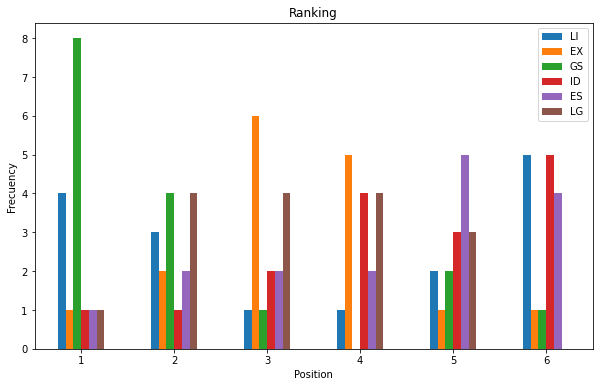

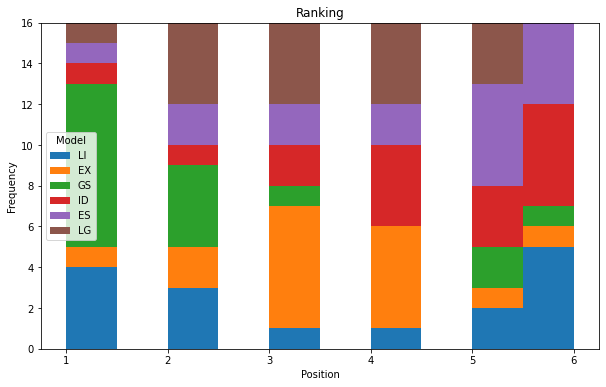

,LI,EX,GS,ID,ES,LG
1,14.0,7.0,32.0,3.0,6.0,1.0
2,13.0,9.0,11.0,7.0,5.0,18.0
3,3.0,23.0,5.0,8.0,9.0,15.0
4,3.0,15.0,2.0,14.0,13.0,16.0
5,8.0,6.0,10.0,16.0,13.0,10.0
6,22.0,3.0,3.0,15.0,17.0,3.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 5 | Valor SIATA: 50.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
74      0.77  1.44  45.52 -0.07  0.03 -0.22  0.03  0.04 -0.03
119     0.69  0.72  54.66  0.41  0.29  0.52  0.31  0.33  0.36
120     0.78  1.05  52.56  0.13  0.14  0.01  0.15  0.05  0.14
160     0.62  0.82  28.06  0.17  0.22  0.19  0.18  0.19  0.18
169     0.75  0.64  50.34  0.36  0.32  0.51  0.33  0.40  0.35

Estacion SIATA: 28 | Cantidad de nodos disponibles: 4 | Valor SIATA: 38.0
          DQ  Dist    Val  w_LI  w_EX  w_GS  w_ID  w_ES  w_LG
Sensor                                                       
58      0.73  0.80  39.83  0.33  0.30  0.39  0.30  0.43  0.31
111     0.73  0.81  51.03  0.28  0.28  0.24  0.28  0.03  0.28
157     0.77  0.86  40.24  0.28  0.27  0.34  0.27  0.38  0.27
213     0.75  1.23  37.78  0.12  0.16  0.04  0.15  0.16  0.13

Estacion SIATA: 31 | Cantidad de nodos disp

,12,28,31,48,69,78,79,80,81,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,
LI,1.11,0.89,1.34,0.30,0.57,0.38,0.59,1.30,2.04,0.32,0.26,1.53,1.20,1.61,0.25,0.60
EX,0.14,0.13,1.22,1.19,0.54,0.52,0.28,0.58,1.42,0.38,0.17,1.50,0.23,2.93,0.22,0.49
GS,0.04,0.12,0.45,0.23,0.55,0.52,0.24,0.19,1.42,0.17,0.25,0.16,0.18,1.22,0.25,0.21
ID,0.15,0.13,1.85,1.57,0.61,0.51,0.25,0.81,1.52,0.26,0.19,2.75,0.21,3.75,0.25,0.98
ES,0.19,0.06,1.75,1.66,0.56,5434.41,0.43,0.77,1.88,0.21,0.18,2.05,0.23,4.70,0.24,0.72
LG,0.14,0.13,1.17,1.40,0.54,0.42,0.23,0.48,0.91,0.22,0.19,2.34,0.25,5.30,0.27,0.64


12,28,31,48,69,78,79,80,81,82,83,84,86,87,88,90
GS,ES,GS,GS,EX,LI,LG,GS,LG,GS,EX,GS,GS,GS,EX,GS
LG,GS,LG,LI,LG,LG,GS,LG,EX,ES,ES,EX,ID,LI,ES,EX
EX,EX,EX,EX,GS,ID,ID,EX,GS,LG,ID,LI,EX,EX,ID,LI
ID,ID,LI,LG,ES,EX,EX,ES,ID,ID,LG,ES,ES,ID,LI,LG
ES,LG,ES,ID,LI,GS,ES,ID,ES,LI,GS,LG,LG,ES,GS,ES
LI,LI,ID,ES,ID,ES,LI,LI,LI,EX,LI,ID,LI,LG,LG,ID


,LI,EX,GS,ID,ES,LG
1,1,3,9,0,1,2
2,2,3,2,1,3,5
3,2,7,2,4,0,1
4,2,2,0,5,4,3
5,2,0,3,2,6,3
6,7,1,0,4,2,2


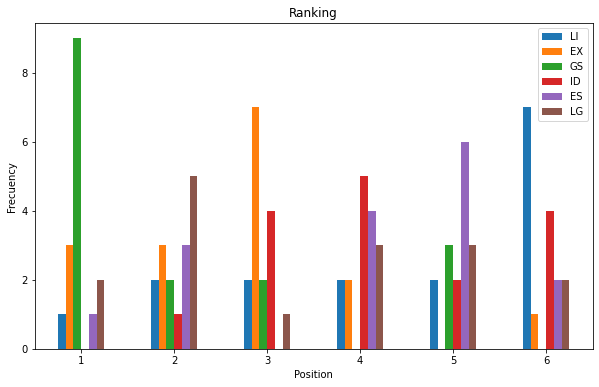

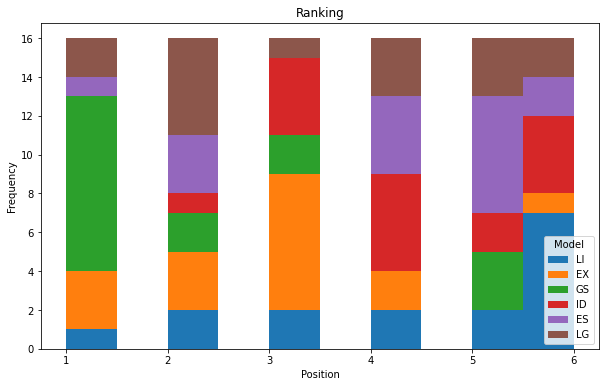

,LI,EX,GS,ID,ES,LG
1,15.0,10.0,41.0,3.0,7.0,3.0
2,15.0,12.0,13.0,8.0,8.0,23.0
3,5.0,30.0,7.0,12.0,9.0,16.0
4,5.0,17.0,2.0,19.0,17.0,19.0
5,10.0,6.0,13.0,18.0,19.0,13.0
6,29.0,4.0,3.0,19.0,19.0,5.0



Final Ranking


,LI,EX,GS,ID,ES,LG
1,15,10,41,3,7,3
2,15,12,13,8,8,23
3,5,30,7,12,9,16
4,5,17,2,19,17,19
5,10,6,13,18,19,13
6,29,4,3,19,19,5


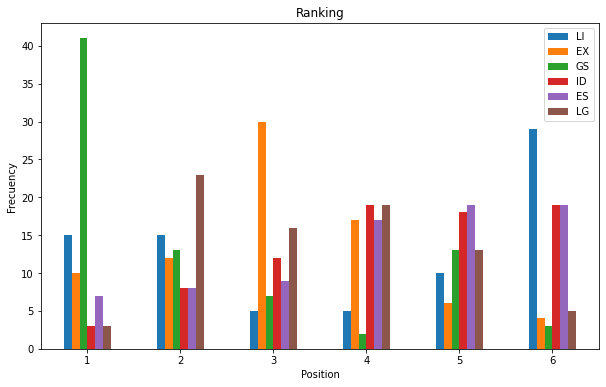

In [557]:
import importlib
importlib.reload(f_DQM)
importlib.reload(f_FS)
import seaborn as sns

cm = sns.light_palette("#990F02", as_cmap=True)

'''
dias = ['03','03']
hora = '14:00:00'

dias = ['14','14']
hora = '07:00:00'

dias = ['17','17']
hora = '19:00:00'

dias = ['21','21']
hora = '11:00:00'
'''

redondeo = 4
por_hora = True

# Fecha del análisis
year = '2020'
mes = '02'
#dias = ['27','27']
#hora = '23:00:00'

# Estación SIATA de referencia
estacionSIATA = 69
cercania = 1.5  # En Kms

ranking = pd.DataFrame()

for dias, hora in zip([['03','03'], ['14','14'], ['17','17'], ['21','21'], ['27','27']], ['14:00:00', '07:00:00', '19:00:00', '11:00:00', '23:00:00']):

    interpolation_dic = {}
    indices = [["SIATA", "LI", "EX", "GS", "ID", "ES", "LG"], ["value", "error"]] #, "PP_lineal", "PP_expo", "Experim"
    interpolation_df = pd.MultiIndex.from_product(indices, names=["Model", "Result"])
    interpolation_df = pd.DataFrame([], index=interpolation_df)

    for estacionSIATA in df_SIATA.codigoSerial.unique():

        resultados = pd.DataFrame(columns=['Sensor','DQ','Dist','Val'])
        resultados.set_index(['Sensor'], inplace=True)
        interpolation_dic[estacionSIATA] = {}

        #Extracción de los datos del nodo SIATA
        datos_SIATA = f_FS.extrac_data_SIATA(df_SIATA, estacionSIATA, year, mes, dias)

        #Limpieza datos SIATA
        datos_SIATA.loc[datos_SIATA['pm25']>999,'pm25']=np.nan
        datos_SIATA.loc[datos_SIATA['pm25']<0,'pm25']=np.nan
        if np.isnan(datos_SIATA.loc[year+'-'+mes+'-'+dias[0]+' '+hora]["pm25"]):
            #print("\n***La estación SIATA", estacionSIATA, "no cuenta con datos en la fecha - hora indicadas")
            interpolation_df[estacionSIATA] = np.nan
            continue

        # Extracción de los datos de los nodos CS de acuerdo con la estación SIATA seleccionada
        fusion, nodosCS = f_FS.extrac_data_CS(df_CS, datos_SIATA, cercania, estacionSIATA, year, mes, dias)
      
        if len(nodosCS) <= 1:
            #print("\n***La estación SIATA", estacionSIATA, "no cuenta con nodos cercanos suficientes que tengan datos en la fecha - hora indicadas")
            interpolation_df[estacionSIATA] = np.nan
            continue

        # PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
        datos_h = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)

        # EXTRACCIÓN DE LOS DATOS A LA HORA INDICADA
        datos_h = datos_h.loc[year+'-'+mes+'-'+dias[0]+' '+hora]
        datos_h = datos_h[['codigoSerial', 'pm25_df', 'pm25_nova', 'latitud', 'longitud']]
        datos_h.dropna(subset=['pm25_df'], inplace=True)

        if len(datos_h) > 2:
            if por_hora:
                DQIndex = DQIndex_x_H[DQIndex_x_H.codigoSerial.isin(nodosCS)]

                # Calcular las dimensiones de incertidumbre y exactitud y caluclar el DQIndex
                DQIndex = DQIndex.groupby(['codigoSerial', 'mes', 'dia', 'hora']).first()
                DQIndex['incer'] = f_DQM.incertidumbre_Horas(fusion, datos_SIATA)
                DQIndex['accu'] = f_DQM.accuracy_Horas(fusion, datos_SIATA)
                DQIndex = DQIndex.fillna(0)
                DQIndex['DQIndex'] = DQIndex['compl']*0.22 + DQIndex['prec']*0.22+ DQIndex['concor']*0.18 + DQIndex['incer']*0.16 + DQIndex['accu']*0.22
                DQIndex = f_FS.multiindex_to_fechaHora(DQIndex)
                #DQIndex = DQIndex[DQIndex.codigoSerial.isin(datos_h.codigoSerial.unique())]
                DQIndex = DQIndex.groupby(['codigoSerial','fechaHora']).first()


                
            data = {'Sensor': [],'lat': [],'lon': [],'DQIndex': [],'values': []}
            for i in range(len(datos_h)):
                if datos_h.iloc[i].notna().pm25_df:
                    nodo = datos_h.iloc[i].codigoSerial
                    data['Sensor'].append(int(nodo))
                    data['lat'].append(datos_h.iloc[i].latitud)
                    data['lon'].append(datos_h.iloc[i].longitud)
                    data['values'].append(datos_h.iloc[i].pm25_df)
                    if por_hora:
                        if nodo in DQIndex.index:
                            data['DQIndex'].append(DQIndex.loc[nodo, year+'-'+mes+'-'+dias[0]+' '+hora]['DQIndex'])
                        else:
                            data['DQIndex'].append(round(DQIndexCS.loc[nodo]["DQ_Index_df"],redondeo)) # DQ Total
                    else:
                        data['DQIndex'].append(round(DQIndexCS.loc[nodo]["DQ_Index_df"],redondeo)) # DQ Total
                    #data['DQIndex'].append(round(random.random(),5))

            datos_SIATAf = datos_SIATA.loc[year+'-'+mes+'-'+dias[0]+' '+hora]
            interpolation_dic[estacionSIATA]["SIATA"] = {"value":round(datos_SIATAf.pm25,redondeo), "error": len(datos_h)}
            interpolation_df.loc[("SIATA", "value"), estacionSIATA] = datos_SIATAf.pm25
            interpolation_df.loc[("SIATA", "error"), estacionSIATA] = len(datos_h)

            interpolation_point = {'Sensor': [datos_SIATAf.codigoSerial],'lat': [datos_SIATAf.latitud],'lon': [datos_SIATAf.longitud],'values': [datos_SIATAf.pm25]}
            print("\nEstacion SIATA:",estacionSIATA, "| Cantidad de nodos disponibles:", len(datos_h), "| Valor SIATA:",datos_SIATAf.pm25)

            '''
            data = {
                'Sensor': ["S1", "S2", "S3", "S4"],
                'lat': [6.256, 6.2567, 6.268, 6.269],
                'lon': [-75.567, -75.5660, -75.5455, -75.5456],
                'DQIndex': [0.1, 0.99, 0.99, 0.1],
                'values': [35, 43, 45, 39]
            }

            data = {
                'Sensor': ["S1"],
                'lat': [6.256],
                'lon': [-75.567],
                'DQIndex': [0.1],
                'values': [35]
            }

            interpolation_point = {
                'Sensor': ["SIATA"],
                'lat': [6.270],
                'lon': [-75.5460],
                'values': [43]
            }
            '''

            # Creación de DataFrames
            sensors_df = pd.DataFrame(data)
            interp_df = pd.DataFrame(interpolation_point)
            
            # Dibuja el mapa con los puntos de los sensores
            #draw_map(sensors_df, interp_df)

            # Calcula las distancias entre sensores y desde los sensores y el punto de interpolación
            dist_iterp, dist_points = calculate_distances(sensors_df, interp_df)
            
            DQs =[]
            for i in range(len(dist_iterp)):
                #print(f'Sensor: {data["Sensor"][i]}, DQ: {data["DQIndex"][i]:.4f}, Distance: {dist_iterp[i]:.2f}, Value: {data["values"][i]:.4f}')
                resultados.loc[data["Sensor"][i]] = {'DQ':round(data["DQIndex"][i], 2), 'Dist':round(dist_iterp[i],2), 'Val':round(data["values"][i],2)}
                DQs.append(data["DQIndex"][i])
            #print(f'DQ Mean: {np.mean(DQs):.4f}, Distancias Mean: {dist_iterp.mean():.2f}')

            # Calcula las matrices de covarianzas para los sesnores 
            values = sensors_df["values"]

            '''
            exper = experim(values, data["DQIndex"], dist_iterp)
            #print(f'** Pesos experimental: {exper.round(4)}')
            resultados['w_PP_EX'] = exper.round(2)
            exper_interp = 0
            for v,p in zip(values, exper):
                exper_interp += (v*p) 
            
            interpolation_df.loc[("PP_EX", "value"), estacionSIATA] = exper_interp
            interpolation_df.loc[("PP_EX", "error"), estacionSIATA] = 0

            lineal_exper = lineal_experim(values, data["DQIndex"], dist_iterp)
            resultados['w_PP_LI'] = lineal_exper.round(2)
            exper_interp = 0
            for v,p in zip(values, lineal_exper):
                exper_interp += (v*p) 
            
            interpolation_df.loc[("PP_LI", "value"), estacionSIATA] = exper_interp
            interpolation_df.loc[("PP_LI", "error"), estacionSIATA] = 0
            '''

            for model in ["LI", "EX", "GS", "ID", "ES", "LG"]:#, "PP_lineal", "PP_expo"]:  
                if model in ["LI", "PP_lineal"] and len(values) < 3:
                    #print("There is not enough values for the linear model - afuea", model)
                    continue

                covariance_C, covariance_b, puntos = covariance_matrix(values, dist_points, data["DQIndex"], dist_iterp, model=model)
                #print(covariance_C)
                #print(covariance_b)

                if (det(covariance_C) == 0) and (model not in ["Experim", "L_experim"]):
                    #print("\n***El modelo", model, "tiene una matriz de covaianzas singular")
                    interpolation_df.loc[(model, "value"), estacionSIATA] = np.nan
                    interpolation_df.loc[(model, "error"), estacionSIATA] = np.nan
                    continue

                # Calcular los valores de los pesos resolviendo el sistema
                lambda_mu = solve(covariance_C, covariance_b)
                lambda_weights = lambda_mu[:-1]
                mu = lambda_mu[-1]
                #print(f'** Pesos {model}: {lambda_weights.round(4)}')
                resultados['w_'+model] = lambda_weights.round(2)
                
                # Calcular el valor interpolado
                value_interpolated = np.sum(lambda_weights * values)

                # Calcular la varianza de kriging
                var_kriging = abs(puntos[0] - np.sum(lambda_weights * covariance_b[:-1]))
                
                #print(f"Valor de los puntos {puntos}")
                if model == 'PP_lineal':
                    var_kriging *=0.5
                interpolation_dic[estacionSIATA][model] = {"value":round(value_interpolated,redondeo), "error": round(var_kriging,redondeo)}
                interpolation_df.loc[(model, "value"), estacionSIATA] = value_interpolated
                interpolation_df.loc[(model, "error"), estacionSIATA] = var_kriging
                #print(f"El valor interpolado usando el modelo {model} es: {round(value_interpolated,redondeo)}, con error: {round(var_kriging,redondeo)}")
                #print(f"Con varianza entre los sensores y el punto de interpolación de {covariance_b}\n")              
            

            print(resultados)
            
            
            #print(f"El valor SIATA es: {round(interpolation_df['values'][0],redondeo)}")
            #print(f"Pesos de los sensores: {[round(x,redondeo) for x in lambda_weights]}")
            #print(f"Calidad de los datos: {data['DQIndex']}")
            #print(f"Distancia de los sensores: {[round(x,redondeo)  for x in dist_iterp]}")
        else:
            #print("\n***La estación SIATA", estacionSIATA, "no tiene nodos suficientes en un radio de", cercania, "km")
            interpolation_df[estacionSIATA] = np.nan

    test = interpolation_df.copy()
    test.dropna(axis=1, inplace=True)
    test.loc[('SIATA','value')]
    error = (test.xs("error", level="Result"))
    error.loc['SIATA'] = 0
    test = test.xs("value", level="Result")
    metrica = error.copy()

    for c in test.columns:
        metrica[c] = ((abs(test[c] - test.loc["SIATA"][c])) + error[c])/test.loc["SIATA"][c]
        test[c] = ((abs(test[c] - test.loc["SIATA"][c])) + error[c]).sort_values().index

    metrica.drop('SIATA', inplace=True)
    test.drop('SIATA', inplace=True)

    print(f'\nFecha y Hora: 2020-02-{dias[0]} {hora}')
    display(metrica.style.format('{:.2f}',).background_gradient(cmap=cm))
    display(test.style.hide())
    rank = (metrica.rank(ascending = False).astype(int)-1).sum(axis=1).sort_values(ascending = False)
    metrica = (metrica.rank(ascending = True).astype(int)).T

    fd = pd.DataFrame(index=list(range(1,len(test)+1)))
    for c in metrica.columns:
        fd[c] = metrica[c].value_counts()
    #fd.sort_index(inplace=True)
    display((fd.fillna(0)).astype(int))
    fd.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
    
    metrica.plot(kind='hist', stacked=True, figsize=(10,6), title='Ranking', xlabel='Position')
    plt.show()
    
    #display(metrica)
    print('\n')

    if ranking.empty:
        ranking = fd.fillna(0).copy()
    else:
        ranking = ranking + fd.fillna(0)
    display(ranking)

print('\nFinal Ranking')
display((ranking.fillna(0)).astype(int))
ranking.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


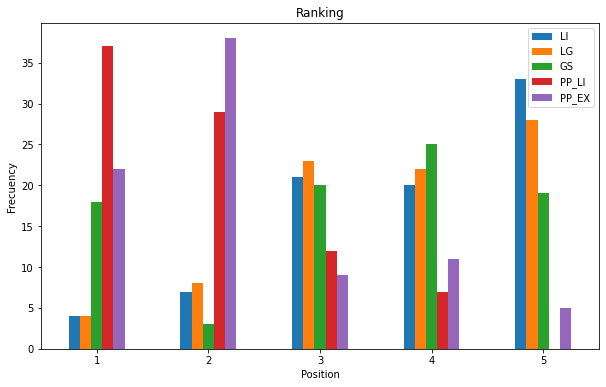

In [579]:
final = pd.DataFrame(index=list(range(1,6)), columns=['LI', 'LG', 'GS', 'PP_LI', 'PP_EX'], 
                     data=[[4,4,18,37,22], 
						   [7,8,3,29,38], 
						   [21,23,20,12,9], 
						   [20,22,25,7,11], 
						   [33,28,19,0,5]])


final.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
plt.savefig("comp-rank-2km.eps", dpi=200, bbox_inches='tight')
plt.show()



Estacion SIATA: 12 | Cantidad de nodos disponibles: 10 | Valor SIATA: 25.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                                       
74      0.63  1.44   8.15     0.09     0.09  0.02  0.03  0.04
77      0.76  0.32  22.10     0.13     0.16  0.63  0.59  0.99
107     0.66  1.68  11.62     0.08     0.08 -0.00  0.01 -0.02
117     0.56  0.69  10.72     0.12     0.12  0.17  0.16  0.38
119     0.58  0.72  11.74     0.12     0.12  0.01  0.02 -0.30
120     0.66  1.05   9.04     0.11     0.11 -0.00  0.01 -0.23
124     0.64  1.95   8.05     0.06     0.06 -0.02 -0.01  0.01
149     0.51  1.55  13.66     0.08     0.07 -0.01  0.00 -0.03
169     0.62  0.64  15.24     0.12     0.13  0.20  0.20  0.13
206     0.64  1.69  12.57     0.08     0.08 -0.01 -0.00  0.03

Estacion SIATA: 28 | Cantidad de nodos disponibles: 10 | Valor SIATA: 37.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                    

,12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,,
LI,0.34,0.68,0.37,0.18,0.87,0.71,0.10,0.21,0.79,0.83,0.60,0.56,0.67,0.51,1.69,0.62,0.67
LG,0.32,0.68,0.44,0.20,0.73,0.70,0.11,1.14,0.72,0.63,0.57,0.84,0.66,0.57,1.05,0.60,0.65
GS,0.10,0.69,0.47,0.41,0.62,0.70,0.11,0.09,0.22,0.52,0.62,0.43,1.02,0.48,1.62,0.73,0.66
PP_LI,0.48,0.67,0.37,0.29,0.74,0.70,0.16,0.27,0.60,0.64,0.11,0.41,0.64,0.51,0.05,0.56,0.61
PP_EX,0.49,0.67,0.36,0.29,0.74,0.70,0.17,0.26,0.61,0.64,0.13,0.42,0.64,0.51,0.01,0.56,0.61


12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
GS,PP_EX,PP_EX,LI,GS,LG,LI,GS,GS,GS,PP_LI,PP_LI,PP_EX,GS,PP_EX,PP_EX,PP_EX
LG,PP_LI,PP_LI,LG,LG,GS,GS,LI,PP_LI,LG,PP_EX,PP_EX,PP_LI,LI,PP_LI,PP_LI,PP_LI
LI,LI,LI,PP_LI,PP_EX,PP_LI,LG,PP_EX,PP_EX,PP_LI,LG,GS,LG,PP_LI,LG,LG,LG
PP_LI,LG,LG,PP_EX,PP_LI,PP_EX,PP_LI,PP_LI,LG,PP_EX,LI,LI,LI,PP_EX,GS,LI,GS
PP_EX,GS,GS,GS,LI,LI,PP_EX,LG,LI,LI,GS,LG,GS,LG,LI,GS,LI


,LI,LG,GS,PP_LI,PP_EX
1,2,1,6,2,6
2,2,4,2,7,2
3,3,6,1,4,3
4,4,3,2,4,4
5,6,3,6,0,2


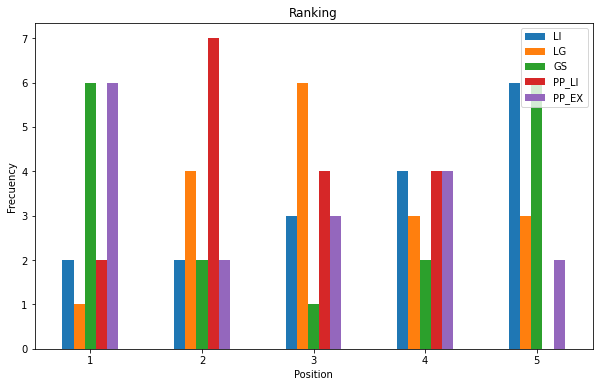

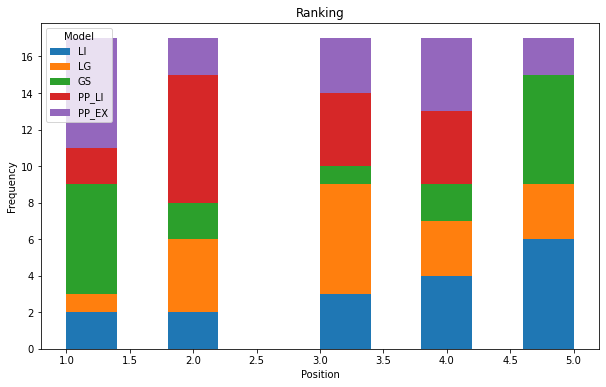

,LI,LG,GS,PP_LI,PP_EX
1,2,1,6,2.0,6
2,2,4,2,7.0,2
3,3,6,1,4.0,3
4,4,3,2,4.0,4
5,6,3,6,0.0,2



Estacion SIATA: 12 | Cantidad de nodos disponibles: 11 | Valor SIATA: 73.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                                       
74      0.78  1.44  75.40     0.09     0.09 -0.02 -0.01 -0.01
77      0.75  0.32  87.02     0.12     0.13  0.64  0.60  1.15
107     0.75  1.68  93.99     0.08     0.08 -0.02 -0.00 -0.04
119     0.77  0.72  77.80     0.12     0.12 -0.01  0.00 -0.48
124     0.73  1.95  90.02     0.06     0.06  0.02  0.02 -0.01
149     0.77  1.55  73.50     0.09     0.08 -0.01 -0.00 -0.05
160     0.64  0.82  48.45     0.11     0.10  0.10  0.10  0.11
169     0.72  0.64  91.22     0.12     0.12  0.30  0.28  0.25
171     0.76  1.66  65.86     0.08     0.08 -0.01 -0.00  0.09
206     0.75  1.69  55.38     0.08     0.07 -0.01 -0.00  0.01
231     0.78  1.95  67.37     0.06     0.07  0.02  0.02 -0.01

Estacion SIATA: 25 | Cantidad de nodos disponibles: 18 | Valor SIATA: 63.0
          DQ  Dist    Val  w_PP_EX  w_PP_L

,12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,,
LI,0.42,6.17,1.19,3.09,2.01,1.13,0.77,2.01,3.87,0.72,0.42,3.16,0.87,1.80,1.44,1.93,0.78
LG,1.35,1.12,1.24,1.70,2.21,5.58,0.78,1.62,0.89,1.32,0.85,2.59,1.94,1.43,2.13,13.64,0.53
GS,0.20,1.33,0.98,1.08,2.27,1.34,0.73,1.40,2.49,0.64,0.39,2.19,1.24,0.76,0.55,16.73,0.18
PP_LI,0.04,0.62,0.93,1.37,0.11,0.17,0.50,1.17,0.97,0.81,0.30,0.43,0.48,0.08,0.19,0.91,0.71
PP_EX,0.03,0.64,0.93,1.37,0.12,0.18,0.50,1.17,0.98,0.82,0.31,0.44,0.48,0.08,0.21,0.92,0.74


12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
PP_EX,PP_LI,PP_EX,GS,PP_LI,PP_LI,PP_EX,PP_LI,LG,GS,PP_LI,PP_LI,PP_LI,PP_LI,PP_LI,PP_LI,GS
PP_LI,PP_EX,PP_LI,PP_LI,PP_EX,PP_EX,PP_LI,PP_EX,PP_LI,LI,PP_EX,PP_EX,PP_EX,PP_EX,PP_EX,PP_EX,LG
GS,LG,GS,PP_EX,LI,LI,GS,GS,PP_EX,PP_LI,GS,GS,LI,GS,GS,LI,PP_LI
LI,GS,LI,LG,LG,GS,LI,LG,GS,PP_EX,LI,LG,GS,LG,LI,LG,PP_EX
LG,LI,LG,LI,GS,LG,LG,LI,LI,LG,LG,LI,LG,LI,LG,GS,LI


,LI,LG,GS,PP_LI,PP_EX
1,0,1,3,10,3
2,1,1,0,5,10
3,4,1,8,2,2
4,5,6,4,0,2
5,7,8,2,0,0


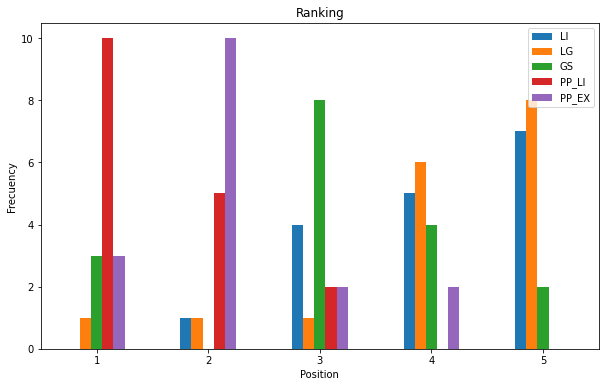

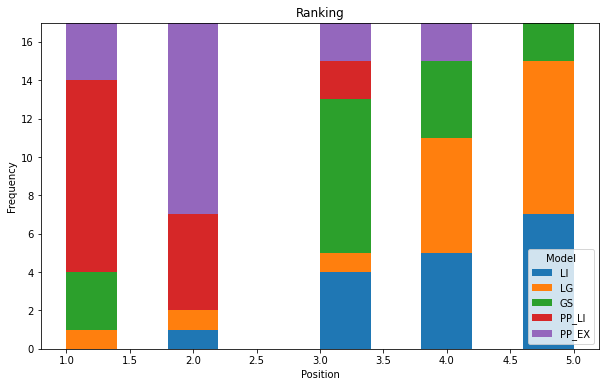

,LI,LG,GS,PP_LI,PP_EX
1,2.0,2,9.0,12.0,9.0
2,3.0,5,2.0,12.0,12.0
3,7.0,7,9.0,6.0,5.0
4,9.0,9,6.0,4.0,6.0
5,13.0,11,8.0,0.0,2.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 11 | Valor SIATA: 17.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                                       
74      0.70  1.44  15.45     0.09     0.09 -0.02 -0.01  0.01
77      0.64  0.32  28.87     0.12     0.13  0.62  0.59  0.79
107     0.77  1.68  19.30     0.08     0.08 -0.02 -0.01 -0.03
120     0.80  1.05  17.23     0.11     0.11  0.08  0.08  0.04
124     0.75  1.95  18.55     0.06     0.07 -0.02 -0.01 -0.04
149     0.67  1.55  18.58     0.08     0.08 -0.01 -0.00 -0.23
160     0.73  0.82  11.76     0.12     0.12  0.10  0.10  0.00
169     0.61  0.64  20.59     0.12     0.11  0.26  0.25  0.33
171     0.64  1.66  17.98     0.08     0.07 -0.01 -0.00  0.22
206     0.73  1.69  15.65     0.08     0.08 -0.01 -0.00 -0.13
231     0.73  1.95  15.10     0.06     0.07  0.02  0.02  0.02

Estacion SIATA: 25 | Cantidad de nodos disponibles: 18 | Valor SIATA: 14.0
          DQ  Dist    Val  w_PP_EX  w_PP_L

,12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,,
LI,0.73,0.29,0.15,0.23,0.24,0.11,0.10,0.75,56.86,2.56,0.59,9.43,1.34,0.96,1.16,0.59,0.83
LG,0.50,0.26,0.09,1.52,0.14,0.35,0.10,1.49,3.28,2.24,0.76,1.17,1.70,0.76,1.35,0.74,1.01
GS,0.62,0.31,0.10,0.94,0.20,0.17,0.10,0.60,4.96,2.15,0.35,13.56,1.55,0.66,0.91,0.91,0.50
PP_LI,0.09,0.21,0.06,0.06,0.06,0.04,0.03,0.43,1.72,2.46,1.22,0.82,0.98,0.30,0.55,0.54,0.94
PP_EX,0.08,0.21,0.06,0.07,0.06,0.04,0.03,0.43,1.73,2.48,1.27,0.84,0.98,0.32,0.56,0.55,0.96


12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
PP_EX,PP_LI,PP_EX,PP_LI,PP_EX,PP_EX,PP_EX,PP_LI,PP_LI,GS,GS,PP_LI,PP_EX,PP_LI,PP_LI,PP_LI,GS
PP_LI,PP_EX,PP_LI,PP_EX,PP_LI,PP_LI,PP_LI,PP_EX,PP_EX,LG,LI,PP_EX,PP_LI,PP_EX,PP_EX,PP_EX,LI
LG,LG,LG,LI,LG,LI,GS,GS,LG,PP_LI,LG,LG,LI,GS,GS,LI,PP_LI
GS,LI,GS,GS,GS,GS,LG,LI,GS,PP_EX,PP_LI,LI,GS,LG,LI,LG,PP_EX
LI,GS,LI,LG,LI,LG,LI,LG,LI,LI,PP_EX,GS,LG,LI,LG,GS,LG


,LI,LG,GS,PP_LI,PP_EX
1,0,0,3,8,6
2,2,1,0,6,8
3,4,7,4,2,0
4,4,3,7,1,2
5,7,6,3,0,1


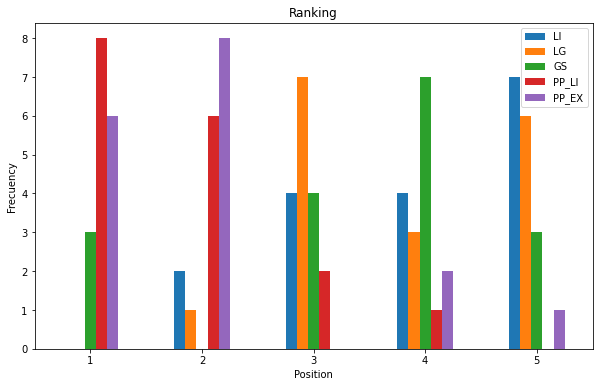

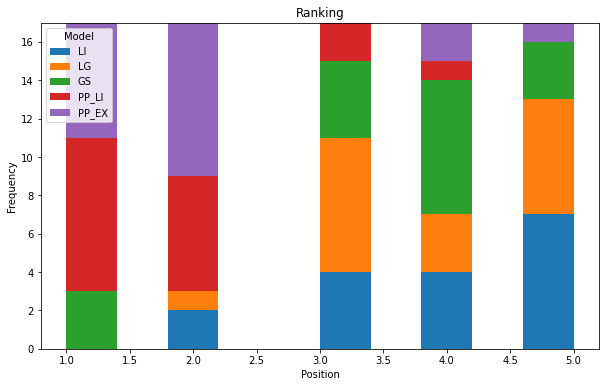

,LI,LG,GS,PP_LI,PP_EX
1,2.0,2.0,12.0,20.0,15.0
2,5.0,6.0,2.0,18.0,20.0
3,11.0,14.0,13.0,8.0,5.0
4,13.0,12.0,13.0,5.0,8.0
5,20.0,17.0,11.0,0.0,3.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 12 | Valor SIATA: 45.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                                       
74      0.62  1.44  48.74     0.08     0.07 -0.02 -0.01 -0.03
77      0.76  0.32  46.83     0.11     0.12  0.63  0.59  1.12
107     0.79  1.68  43.38     0.07     0.07 -0.02 -0.01 -0.03
119     0.80  0.72  44.82     0.11     0.11 -0.01  0.00 -0.44
120     0.76  1.05  34.12     0.10     0.09  0.08  0.08  0.06
124     0.71  1.95  29.46     0.05     0.05 -0.02 -0.01 -0.02
149     0.75  1.55  50.88     0.08     0.07 -0.01 -0.00 -0.04
160     0.73  0.82  28.84     0.10     0.10  0.10  0.10  0.16
169     0.78  0.64  44.59     0.11     0.11  0.26  0.25  0.17
171     0.73  1.66  41.08     0.07     0.07 -0.01 -0.00  0.07
206     0.75  1.69  41.61     0.07     0.07 -0.01 -0.00 -0.00
231     0.76  1.95  34.14     0.06     0.06  0.02  0.02 -0.01

Estacion SIATA: 25 | Cantidad de nodos disponibles: 17 

,12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,,
LI,0.11,0.50,0.09,0.00,1.36,0.07,0.31,0.28,0.40,0.11,0.51,1.21,0.05,1.99,0.42,0.89,0.11
LG,1.25,0.06,0.16,0.03,0.75,0.52,0.33,0.30,0.36,0.60,0.47,0.23,0.09,0.20,0.42,0.47,0.40
GS,0.03,0.10,0.13,0.05,0.58,0.37,0.31,0.31,0.78,0.20,0.40,0.21,0.15,0.20,0.15,1.42,0.01
PP_LI,0.09,0.03,0.09,0.04,0.41,0.03,0.18,0.22,0.06,0.00,0.71,0.08,0.01,0.20,0.07,0.02,0.27
PP_EX,0.09,0.04,0.09,0.04,0.41,0.03,0.17,0.22,0.06,0.00,0.73,0.09,0.01,0.19,0.07,0.03,0.28


12,28,31,38,44,48,69,78,79,80,82,83,84,86,87,88,90
GS,PP_LI,PP_LI,LI,PP_EX,PP_LI,PP_EX,PP_EX,PP_EX,PP_EX,GS,PP_LI,PP_LI,PP_EX,PP_LI,PP_LI,GS
PP_EX,PP_EX,PP_EX,LG,PP_LI,PP_EX,PP_LI,PP_LI,PP_LI,PP_LI,LG,PP_EX,PP_EX,PP_LI,PP_EX,PP_EX,LI
PP_LI,LG,LI,PP_LI,GS,LI,GS,LI,LG,LI,LI,GS,LI,LG,GS,LG,PP_LI
LI,GS,GS,PP_EX,LG,GS,LI,LG,LI,GS,PP_LI,LG,LG,GS,LI,LI,PP_EX
LG,LI,LG,GS,LI,LG,LG,GS,GS,LG,PP_EX,LI,GS,LI,LG,GS,LG


,LI,LG,GS,PP_LI,PP_EX
1,1,0,3,7,6
2,1,2,0,6,8
3,6,4,4,3,0
4,5,4,5,1,2
5,4,7,5,0,1


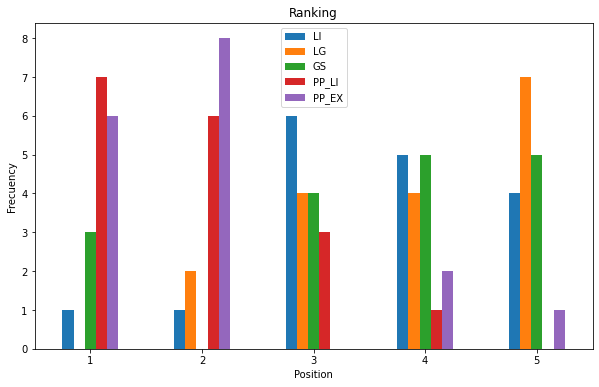

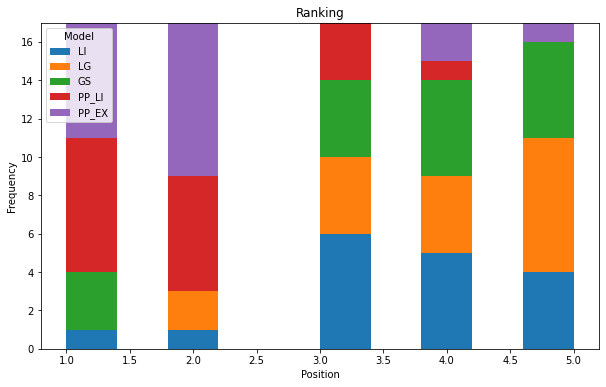

,LI,LG,GS,PP_LI,PP_EX
1,3.0,2.0,15.0,27.0,21.0
2,6.0,8.0,2.0,24.0,28.0
3,17.0,18.0,17.0,11.0,5.0
4,18.0,16.0,18.0,6.0,10.0
5,24.0,24.0,16.0,0.0,4.0



Estacion SIATA: 12 | Cantidad de nodos disponibles: 11 | Valor SIATA: 50.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI  w_LI  w_LG  w_GS
Sensor                                                       
74      0.77  1.44  45.52     0.09     0.09 -0.04 -0.02 -0.02
107     0.72  1.68  53.82     0.08     0.08 -0.04 -0.01 -0.04
119     0.69  0.72  54.66     0.12     0.12  0.37  0.33  0.80
120     0.78  1.05  52.56     0.11     0.11  0.14  0.13  0.21
124     0.77  1.95  46.07     0.06     0.07 -0.03 -0.01 -0.13
149     0.64  1.55  49.12     0.08     0.08  0.01  0.02 -0.36
160     0.62  0.82  28.06     0.11     0.11  0.20  0.19 -0.00
169     0.75  0.64  50.34     0.12     0.13  0.38  0.35  0.43
171     0.68  1.66  43.68     0.08     0.07 -0.02 -0.01  0.26
206     0.71  1.69  37.59     0.08     0.08 -0.03 -0.01 -0.22
231     0.77  1.95  44.91     0.06     0.07  0.06  0.06  0.09

Estacion SIATA: 28 | Cantidad de nodos disponibles: 9 | Valor SIATA: 38.0
          DQ  Dist    Val  w_PP_EX  w_PP_LI

,12,28,31,38,48,69,78,79,80,81,82,83,84,86,87,88,90
Model,,,,,,,,,,,,,,,,,
LI,0.36,0.62,1.17,0.55,0.16,0.77,0.39,0.78,1.01,2.04,0.26,2.02,1.14,0.07,1.29,0.18,0.42
LG,2.56,0.43,0.20,0.41,0.22,0.54,0.42,3.68,0.27,0.91,0.43,0.16,5.61,0.25,0.37,0.56,0.32
GS,0.15,0.03,0.27,0.37,0.36,0.55,0.57,3.08,0.39,1.42,0.17,0.24,0.26,0.14,0.49,1.27,0.27
PP_LI,0.07,0.21,0.21,0.18,0.20,0.45,0.29,0.18,0.24,0.35,0.44,0.25,0.31,0.02,0.19,0.11,0.10
PP_EX,0.08,0.21,0.21,0.18,0.20,0.45,0.30,0.20,0.24,0.37,0.45,0.25,0.32,0.02,0.20,0.12,0.11


12,28,31,38,48,69,78,79,80,81,82,83,84,86,87,88,90
PP_LI,GS,LG,PP_LI,LI,PP_LI,PP_LI,PP_LI,PP_LI,PP_LI,GS,LG,GS,PP_EX,PP_LI,PP_LI,PP_LI
PP_EX,PP_LI,PP_LI,PP_EX,PP_LI,PP_EX,PP_EX,PP_EX,PP_EX,PP_EX,LI,GS,PP_LI,PP_LI,PP_EX,PP_EX,PP_EX
GS,PP_EX,PP_EX,GS,PP_EX,LG,LI,LI,LG,LG,LG,PP_LI,PP_EX,LI,LG,LI,GS
LI,LG,GS,LG,LG,GS,LG,GS,GS,GS,PP_LI,PP_EX,LI,GS,GS,LG,LG
LG,LI,LI,LI,GS,LI,GS,LG,LI,LI,PP_EX,LI,LG,LG,LI,GS,LI


,LI,LG,GS,PP_LI,PP_EX
1,1,2,3,10,1
2,1,0,1,5,10
3,4,5,3,1,4
4,2,6,7,1,1
5,9,4,3,0,1


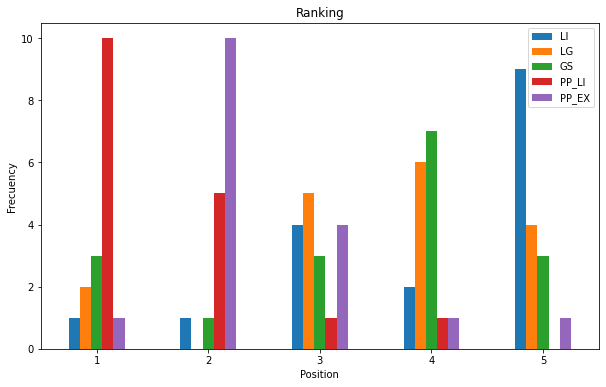

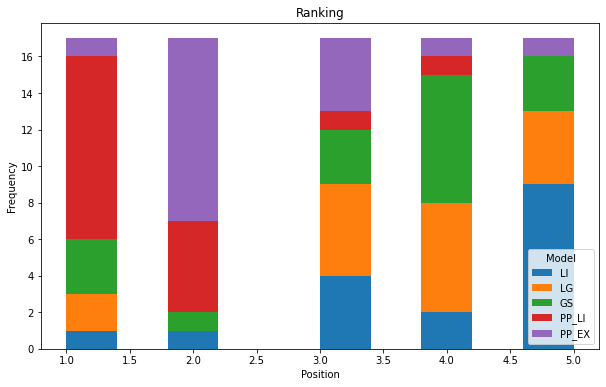

,LI,LG,GS,PP_LI,PP_EX
1,4.0,4.0,18.0,37.0,22.0
2,7.0,8.0,3.0,29.0,38.0
3,21.0,23.0,20.0,12.0,9.0
4,20.0,22.0,25.0,7.0,11.0
5,33.0,28.0,19.0,0.0,5.0



Final Ranking


,LI,LG,GS,PP_LI,PP_EX
1,4,4,18,37,22
2,7,8,3,29,38
3,21,23,20,12,9
4,20,22,25,7,11
5,33,28,19,0,5


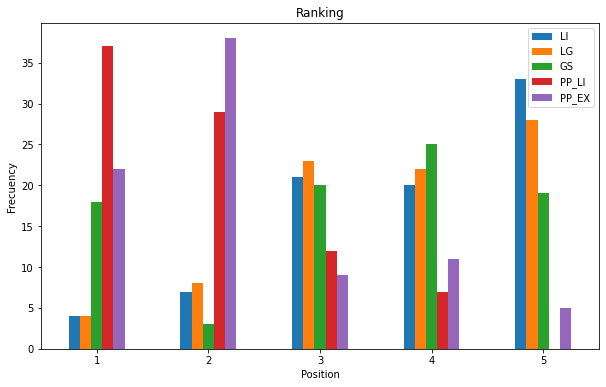

In [569]:
import importlib
importlib.reload(f_DQM)
importlib.reload(f_FS)
import seaborn as sns

cm = sns.light_palette("#990F02", as_cmap=True)

'''
dias = ['03','03']
hora = '14:00:00'

dias = ['14','14']
hora = '07:00:00'

dias = ['17','17']
hora = '19:00:00'

dias = ['21','21']
hora = '11:00:00'
'''

redondeo = 4
por_hora = True

# Fecha del análisis
year = '2020'
mes = '02'
#dias = ['27','27']
#hora = '23:00:00'

# Estación SIATA de referencia
estacionSIATA = 69
cercania = 2  # En Kms

ranking = pd.DataFrame()


for dias, hora in zip([['03','03'], ['14','14'], ['17','17'], ['21','21'], ['27','27']], ['14:00:00', '07:00:00', '19:00:00', '11:00:00', '23:00:00']):

    interpolation_dic = {}
    indices = [["SIATA", "LI", "LG", "GS", "PP_LI", "PP_EX"], ["value", "error"]] #, "PP_lineal", "PP_expo", "Experim"
    interpolation_df = pd.MultiIndex.from_product(indices, names=["Model", "Result"])
    interpolation_df = pd.DataFrame([], index=interpolation_df)

    for estacionSIATA in df_SIATA.codigoSerial.unique():

        resultados = pd.DataFrame(columns=['Sensor','DQ','Dist','Val'])
        resultados.set_index(['Sensor'], inplace=True)
        interpolation_dic[estacionSIATA] = {}

        #Extracción de los datos del nodo SIATA
        datos_SIATA = f_FS.extrac_data_SIATA(df_SIATA, estacionSIATA, year, mes, dias)

        #Limpieza datos SIATA
        datos_SIATA.loc[datos_SIATA['pm25']>999,'pm25']=np.nan
        datos_SIATA.loc[datos_SIATA['pm25']<0,'pm25']=np.nan
        if np.isnan(datos_SIATA.loc[year+'-'+mes+'-'+dias[0]+' '+hora]["pm25"]):
            #print("\n***La estación SIATA", estacionSIATA, "no cuenta con datos en la fecha - hora indicadas")
            interpolation_df[estacionSIATA] = np.nan
            continue

        # Extracción de los datos de los nodos CS de acuerdo con la estación SIATA seleccionada
        fusion, nodosCS = f_FS.extrac_data_CS(df_CS, datos_SIATA, cercania, estacionSIATA, year, mes, dias)
      
        if len(nodosCS) <= 1:
            #print("\n***La estación SIATA", estacionSIATA, "no cuenta con nodos cercanos suficientes que tengan datos en la fecha - hora indicadas")
            interpolation_df[estacionSIATA] = np.nan
            continue

        # PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
        datos_h = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)

        # EXTRACCIÓN DE LOS DATOS A LA HORA INDICADA
        datos_h = datos_h.loc[year+'-'+mes+'-'+dias[0]+' '+hora]
        datos_h = datos_h[['codigoSerial', 'pm25_df', 'pm25_nova', 'latitud', 'longitud']]
        datos_h.dropna(subset=['pm25_df'], inplace=True)

        if len(datos_h) > 2:
            if por_hora:
                DQIndex = DQIndex_x_H[DQIndex_x_H.codigoSerial.isin(nodosCS)]

                # Calcular las dimensiones de incertidumbre y exactitud y caluclar el DQIndex
                DQIndex = DQIndex.groupby(['codigoSerial', 'mes', 'dia', 'hora']).first()
                DQIndex['incer'] = f_DQM.incertidumbre_Horas(fusion, datos_SIATA)
                DQIndex['accu'] = f_DQM.accuracy_Horas(fusion, datos_SIATA)
                DQIndex = DQIndex.fillna(0)
                DQIndex['DQIndex'] = DQIndex['compl']*0.22 + DQIndex['prec']*0.22+ DQIndex['concor']*0.18 + DQIndex['incer']*0.16 + DQIndex['accu']*0.22
                DQIndex = f_FS.multiindex_to_fechaHora(DQIndex)
                #DQIndex = DQIndex[DQIndex.codigoSerial.isin(datos_h.codigoSerial.unique())]
                DQIndex = DQIndex.groupby(['codigoSerial','fechaHora']).first()

            
            data = {'Sensor': [],'lat': [],'lon': [],'DQIndex': [],'values': []}
            for i in range(len(datos_h)):
                if datos_h.iloc[i].notna().pm25_df:
                    nodo = datos_h.iloc[i].codigoSerial
                    data['Sensor'].append(int(nodo))
                    data['lat'].append(datos_h.iloc[i].latitud)
                    data['lon'].append(datos_h.iloc[i].longitud)
                    data['values'].append(datos_h.iloc[i].pm25_df)
                    if por_hora:
                        if nodo in DQIndex.index:
                            data['DQIndex'].append(DQIndex.loc[nodo, year+'-'+mes+'-'+dias[0]+' '+hora]['DQIndex'])
                        else:
                            data['DQIndex'].append(round(DQIndexCS.loc[nodo]["DQ_Index_df"],redondeo)) # DQ Total
                    else:
                        data['DQIndex'].append(round(DQIndexCS.loc[nodo]["DQ_Index_df"],redondeo)) # DQ Total
                    #data['DQIndex'].append(round(random.random(),5))

            datos_SIATAf = datos_SIATA.loc[year+'-'+mes+'-'+dias[0]+' '+hora]
            interpolation_dic[estacionSIATA]["SIATA"] = {"value":round(datos_SIATAf.pm25,redondeo), "error": len(datos_h)}
            interpolation_df.loc[("SIATA", "value"), estacionSIATA] = datos_SIATAf.pm25
            interpolation_df.loc[("SIATA", "error"), estacionSIATA] = len(datos_h)

            interpolation_point = {'Sensor': [datos_SIATAf.codigoSerial],'lat': [datos_SIATAf.latitud],'lon': [datos_SIATAf.longitud],'values': [datos_SIATAf.pm25]}
            print("\nEstacion SIATA:",estacionSIATA, "| Cantidad de nodos disponibles:", len(datos_h), "| Valor SIATA:",datos_SIATAf.pm25)
            
            '''
            data = {
                'Sensor': ["S1", "S2", "S3", "S4"],
                'lat': [6.256, 6.2567, 6.268, 6.269],
                'lon': [-75.567, -75.5660, -75.5455, -75.5456],
                'DQIndex': [0.1, 0.99, 0.99, 0.1],
                'values': [35, 43, 45, 39]
            }

            data = {
                'Sensor': ["S1"],
                'lat': [6.256],
                'lon': [-75.567],
                'DQIndex': [0.1],
                'values': [35]
            }

            interpolation_point = {
                'Sensor': ["SIATA"],
                'lat': [6.270],
                'lon': [-75.5460],
                'values': [43]
            }
            '''

            # Creación de DataFrames
            sensors_df = pd.DataFrame(data)
            interp_df = pd.DataFrame(interpolation_point)
            
            # Dibuja el mapa con los puntos de los sensores
            #draw_map(sensors_df, interp_df)

            # Calcula las distancias entre sensores y desde los sensores y el punto de interpolación
            dist_iterp, dist_points = calculate_distances(sensors_df, interp_df)
            
            DQs =[]
            for i in range(len(dist_iterp)):
                #print(f'Sensor: {data["Sensor"][i]}, DQ: {data["DQIndex"][i]:.4f}, Distance: {dist_iterp[i]:.2f}, Value: {data["values"][i]:.4f}')
                resultados.loc[data["Sensor"][i]] = {'DQ':round(data["DQIndex"][i], 2), 'Dist':round(dist_iterp[i],2), 'Val':round(data["values"][i],2)}
                DQs.append(data["DQIndex"][i])
            #print(f'DQ Mean: {np.mean(DQs):.4f}, Distancias Mean: {dist_iterp.mean():.2f}')

            # Calcula las matrices de covarianzas para los sesnores 
            values = sensors_df["values"]

            exper = experim(values, data["DQIndex"], dist_iterp)
            #print(f'** Pesos experimental: {exper.round(4)}')
            resultados['w_PP_EX'] = exper.round(2)
            exper_interp = 0
            for v,p in zip(values, exper):
                exper_interp += (v*p) 
            
            interpolation_df.loc[("PP_EX", "value"), estacionSIATA] = exper_interp
            interpolation_df.loc[("PP_EX", "error"), estacionSIATA] = 0

            lineal_exper = lineal_experim(values, data["DQIndex"], dist_iterp)
            resultados['w_PP_LI'] = lineal_exper.round(2)
            exper_interp = 0
            for v,p in zip(values, lineal_exper):
                exper_interp += (v*p) 
            
            interpolation_df.loc[("PP_LI", "value"), estacionSIATA] = exper_interp
            interpolation_df.loc[("PP_LI", "error"), estacionSIATA] = 0

            for model in ["LI", "LG", "GS"]:#, "PP_lineal", "PP_expo"]:
                if model in ["LI", "PP_lineal"] and len(values) < 3:
                    #print("There is not enough values for the linear model - afuea", model)
                    continue

                covariance_C, covariance_b, puntos = covariance_matrix(values, dist_points, data["DQIndex"], dist_iterp, model=model)
                #print(covariance_C)
                #print(covariance_b)

                if (det(covariance_C) == 0) and (model not in ["Experim", "L_experim"]):
                    #print("\n***El modelo", model, "tiene una matriz de covaianzas singular")
                    interpolation_df.loc[(model, "value"), estacionSIATA] = np.nan
                    interpolation_df.loc[(model, "error"), estacionSIATA] = np.nan
                    continue

                # Calcular los valores de los pesos resolviendo el sistema
                lambda_mu = solve(covariance_C, covariance_b)
                lambda_weights = lambda_mu[:-1]
                mu = lambda_mu[-1]
                #print(f'** Pesos {model}: {lambda_weights.round(4)}')
                resultados['w_'+model] = lambda_weights.round(2)
                
                # Calcular el valor interpolado
                value_interpolated = np.sum(lambda_weights * values)

                # Calcular la varianza de kriging
                var_kriging = abs(puntos[0] - np.sum(lambda_weights * covariance_b[:-1]))
                
                #print(f"Valor de los puntos {puntos}")
                if model == 'PP_lineal':
                    var_kriging *=0.5
                interpolation_dic[estacionSIATA][model] = {"value":round(value_interpolated,redondeo), "error": round(var_kriging,redondeo)}
                interpolation_df.loc[(model, "value"), estacionSIATA] = value_interpolated
                interpolation_df.loc[(model, "error"), estacionSIATA] = var_kriging
                #print(f"El valor interpolado usando el modelo {model} es: {round(value_interpolated,redondeo)}, con error: {round(var_kriging,redondeo)}")
                #print(f"Con varianza entre los sensores y el punto de interpolación de {covariance_b}\n")              
            

            print(resultados)
            
            
            #print(f"El valor SIATA es: {round(interpolation_df['values'][0],redondeo)}")
            #print(f"Pesos de los sensores: {[round(x,redondeo) for x in lambda_weights]}")
            #print(f"Calidad de los datos: {data['DQIndex']}")
            #print(f"Distancia de los sensores: {[round(x,redondeo)  for x in dist_iterp]}")
        else:
            #print("\n***La estación SIATA", estacionSIATA, "no tiene nodos suficientes en un radio de", cercania, "km")
            interpolation_df[estacionSIATA] = np.nan

    test = interpolation_df.copy()
    test.dropna(axis=1, inplace=True)
    test.loc[('SIATA','value')]
    error = (test.xs("error", level="Result"))
    error.loc['SIATA'] = 0
    test = test.xs("value", level="Result")
    metrica = error.copy()

    for c in test.columns:
        metrica[c] = ((abs(test[c] - test.loc["SIATA"][c])) + error[c])/test.loc["SIATA"][c]
        test[c] = ((abs(test[c] - test.loc["SIATA"][c])) + error[c]).sort_values().index

    metrica.drop('SIATA', inplace=True)
    test.drop('SIATA', inplace=True)

    print(f'\nFecha y Hora: 2020-02-{dias[0]} {hora}')
    display(metrica.style.format('{:.2f}',).background_gradient(cmap=cm))
    display(test.style.hide())
    rank = (metrica.rank(ascending = False).astype(int)-1).sum(axis=1).sort_values(ascending = False)
    metrica = (metrica.rank(ascending = True).astype(int)).T

    fd = pd.DataFrame(index=list(range(1,len(test)+1)))
    for c in metrica.columns:
        fd[c] = metrica[c].value_counts()
    #fd.sort_index(inplace=True)
    display((fd.fillna(0)).astype(int))
    fd.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
    
    metrica.plot(kind='hist', stacked=True, figsize=(10,6), title='Ranking', xlabel='Position')
    plt.show()
    
    #display(metrica)
    print('\n')

    if ranking.empty:
        ranking = fd.fillna(0).copy()
    else:
        ranking = ranking + fd.fillna(0)
    display(ranking)

print('\nFinal Ranking')
display((ranking.fillna(0)).astype(int))
ranking.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
plt.show()

In [571]:
cm = sns.light_palette("#990F02", as_cmap=True)


ind = ['LI', 'LG', 'GS', 'PP_LI', 'PP_EX']
cols = [12, 28, 69,	78,	79,	81,	82,	83,	84,	88]
vals = [[5.62, 2.25, 0.40, 2.20, 1.59, 1.49, 23.89, 1.60, 1.33, 0.41],
        [1.91, 1.90, 0.48, 4.41, 0.85, 0.71, 0.79, 0.90, 1.34, 0.22],
        [1.47, 0.95, 0.38, 3.18, 1.04, 0.67, 0.76, 0.78, 0.71, 0.16],
        [0.17, 0.28, 0.29, 0.50, 0.53, 0.50, 0.55, 0.48, 0.49, 0.14],
        [0.17, 0.28, 0.29, 0.50, 0.53, 0.54, 0.56, 0.48, 0.50, 0.14]]
        

promedio = pd.DataFrame(index=ind, columns=cols, data=vals)

'''
	12	28	69	78	79	81	82	83	84	88
Model										
LI	5.62	2.25	0.40	2.20	1.59	1.49	23.89	1.60	1.33	0.41
LG	1.91	1.90	0.48	4.41	0.85	0.71	0.79	0.90	1.34	0.22
GS	1.47	0.95	0.38	3.18	1.04	0.67	0.76	0.78	0.71	0.16
PP_LI	0.17	0.28	0.29	0.50	0.53	0.50	0.55	0.48	0.49	0.14
PP_EX	0.17	0.28	0.29	0.50	0.53	0.54	0.56	0.48	0.50	0.14
'''


display(promedio.style.format('{:.2f}',).background_gradient(cmap=cm))

,12,28,69,78,79,81,82,83,84,88
LI,5.62,2.25,0.40,2.20,1.59,1.49,23.89,1.60,1.33,0.41
LG,1.91,1.90,0.48,4.41,0.85,0.71,0.79,0.90,1.34,0.22
GS,1.47,0.95,0.38,3.18,1.04,0.67,0.76,0.78,0.71,0.16
PP_LI,0.17,0.28,0.29,0.50,0.53,0.50,0.55,0.48,0.49,0.14
PP_EX,0.17,0.28,0.29,0.50,0.53,0.54,0.56,0.48,0.50,0.14


<Axes: title={'center': 'Ranking'}, xlabel='Position', ylabel='Frequency'>

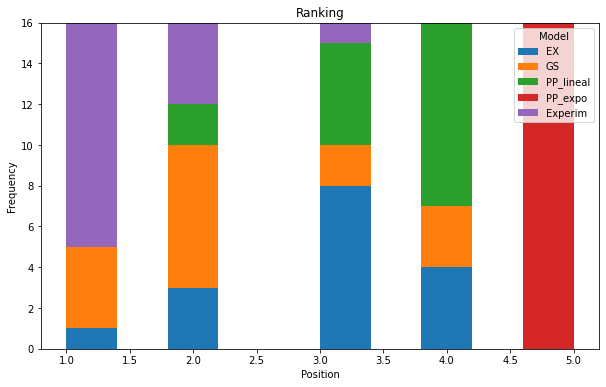

In [349]:
df = (metrica.rank(ascending = True).astype(int)).T
df.plot(kind='hist', stacked=True, figsize=(10,6), title='Ranking', xlabel='Position')

,EX,GS,PP_lineal,PP_expo,Experim
1,1,4,0,0,11
2,3,7,2,0,4
3,8,2,5,0,1
4,4,3,9,0,0
5,0,0,0,16,0


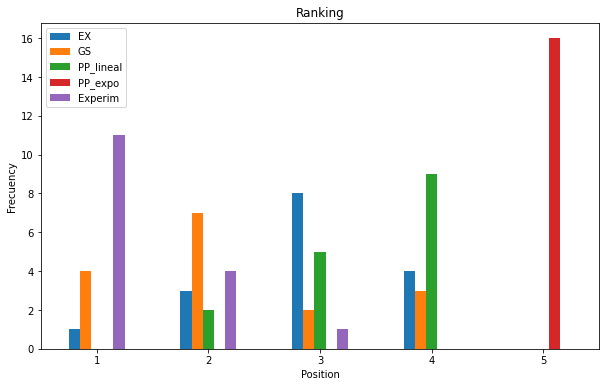

In [371]:
fd = pd.DataFrame(index=[1,2,3,4,5])
for c in df.columns:
    fd[c] = df[c].value_counts()

fd.plot(kind='bar', figsize=(10,6), rot=0, title= 'Ranking', xlabel='Position', ylabel='Frecuency')
(fd.fillna(0)).astype(int)

c=1, c0=0, a=1


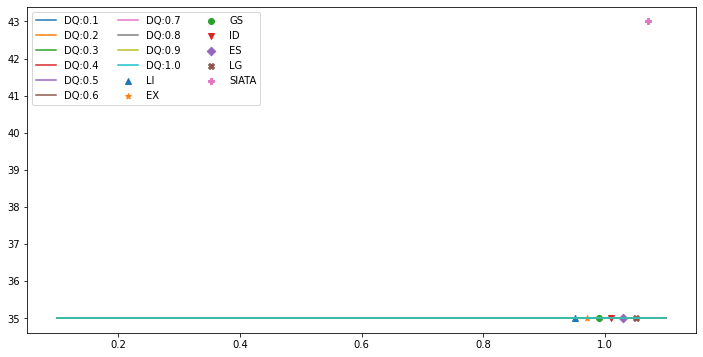

In [577]:
model = "PP"

plt.figure(figsize=(12, 6))

for a in np.arange(0.1,1.1,0.1):
    valores_distance = []
    for b in np.arange(0.1,1.2,0.1):
        covariance_C, covariance_b = covariance_matrix(values, dist_points, data["DQIndex"], [a, b], dist_iterp, model=model)

        # Calcular los valores de los pesos resolviendo el sistema
        lambda_mu = solve(covariance_C, covariance_b)
        lambda_weights = lambda_mu[:-1]
        mu = lambda_mu[-1]

        # Calcular el valor interpolado
        value_interpolated = np.sum(lambda_weights * values)
        #print(f"El valor interpolado usando el modelo {model} es: {round(value_interpolated,4)}")
        valores_distance.append(value_interpolated)
    plt.plot(np.arange(0.1,1.2,0.1), valores_distance, label="DQ:"+str(round(a,1)))


n = 0.95
valores = []
for model in zip(["LI", "EX", "GS", "ID", "ES", "LG"], ["^", "*", "o", "v", "D", "X"]):
    
    covariance_C, covariance_b = covariance_matrix(values, dist_points, data["DQIndex"], [a, b], dist_iterp, model=model[0])

    # Calcular los valores de los pesos resolviendo el sistema
    lambda_mu = solve(covariance_C, covariance_b)
    lambda_weights = lambda_mu[:-1]
    mu = lambda_mu[-1]

    # Calcular el valor interpolado
    value_interpolated = np.sum(lambda_weights * values)
    #print(f"El valor interpolado usando el modelo {model} es: {round(value_interpolated,4)}")
    valores.append(value_interpolated)
    area = (30 * np.random.rand(1))**2

    plt.scatter(n, value_interpolated, marker=model[1], label=model[0])
    n+=0.02

plt.scatter(n, interpolation_df['values'][0], marker='P', label='SIATA')

plt.legend(loc='best', ncol=3)
plt.show()


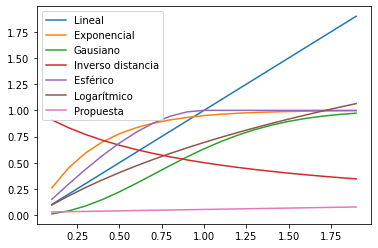

In [48]:
c0 = 0
c = 1
a = 1

lineal = []
exponencial = []
gausiano = []
inverso_distancia = []
esferico = []
logaritmico = []
propuesta = []

for d in np.arange(0.1,2,0.1):
    lineal.append(c0 + (c*d)) # Modelo lineal
    exponencial.append(c0 + c*(1-np.exp(-(3*d)/a))) # Modelo exponencial
    gausiano.append(c0 + c*(1-np.exp(-((d/a)**2)))) # Modelo Gausiano
    inverso_distancia.append(c0 + c/(d + 1)) # Modelo inverso a la distancia
    if d > a:  # Modelo esférico
        esferico.append(c0 + c)
    else:
        esferico.append(c0 + c*(((3*d)/(2*a)) - ((d**3)/(2*(a**3)))))
    logaritmico.append(c0 + c*np.log(d + 1))
    propuesta.append(c0 + c*((1 + (d)) / (1 + np.mean([36,38])**1)))

plt.plot(np.arange(0.1,2,0.1), lineal, label="Lineal")
plt.plot(np.arange(0.1,2,0.1), exponencial, label="Exponencial")
plt.plot(np.arange(0.1,2,0.1), gausiano, label="Gausiano")
plt.plot(np.arange(0.1,2,0.1), inverso_distancia, label="Inverso distancia")
plt.plot(np.arange(0.1,2,0.1), esferico, label="Esférico")
plt.plot(np.arange(0.1,2,0.1), logaritmico, label="Logarítmico")
plt.plot(np.arange(0.1,2,0.1), propuesta, label="Propuesta")
plt.legend()
plt.show()
 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


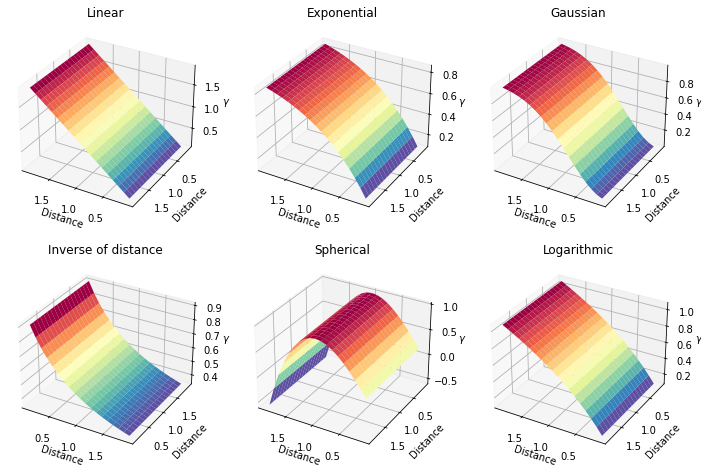

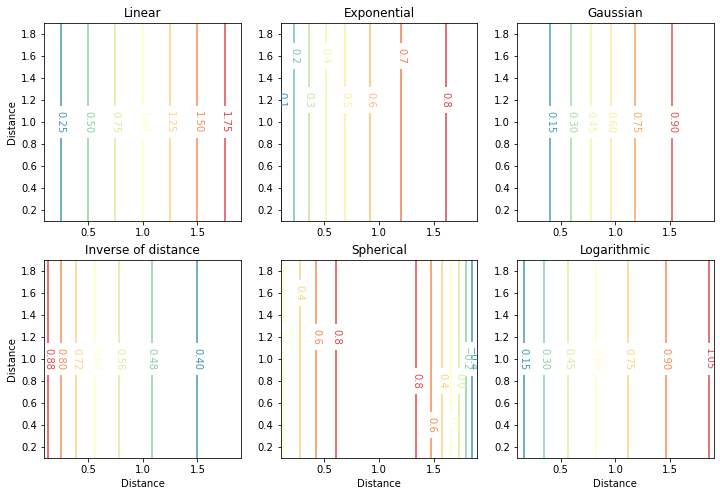

In [71]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(0.1,2,0.1), np.arange(0.1,2,0.1))

lineal = c0 + (c*(X/a)) # Modelo lineal
exponencial =  c0 + c*(1-np.exp(-(X)/a)) # Modelo exponencial
gausiano = c0 + c*(1-np.exp(-((X/a)**2))) # Modelo Gausiano
inverso_distancia = c0 + c/(X + 1) # Modelo inverso a la distancia
esferico = c0 + c*(((3*X)/(2*a)) - ((X**3)/(2*(a**3))))
logaritmico = c0 + c*np.log(X + 1)
propuesta = c0 + c*((1 + (X)) / (1 + np.mean([36,38])**1))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(231, projection = '3d')
ax.set_title("Linear")
axlineal = ax.plot_surface(X, Y, lineal, cmap = 'Spectral_r')
ax.view_init(30, 120)

ax.xaxis.labelpad=0.1
ax.set_xlabel('Distance')      # <====== This works
ax.set_ylabel('Distance') # <====== This doesn't work
ax.zaxis.labelpad=-0.7
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

ax2 = fig.add_subplot(232, projection = '3d')
ax2.set_title("Exponential")
axexponencial = ax2.plot_surface(X, Y, exponencial, cmap = 'Spectral_r')
ax2.view_init(30, 120)

ax2.xaxis.labelpad=0.1
ax2.set_xlabel('Distance')      # <====== This works
ax2.set_ylabel('Distance') # <====== This doesn't work
ax2.zaxis.labelpad=-0.7
ax2.zaxis.set_rotate_label(False)
ax2.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

ax3 = fig.add_subplot(233, projection = '3d')
ax3.set_title("Gaussian")
axgausiano = ax3.plot_surface(X, Y, gausiano, cmap = 'Spectral_r')
ax3.view_init(30, 120)

ax3.xaxis.labelpad=0.1
ax3.set_xlabel('Distance')      # <====== This works
ax3.set_ylabel('Distance') # <====== This doesn't work
ax3.zaxis.labelpad=-0.7
ax3.zaxis.set_rotate_label(False)
ax3.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

ax4 = fig.add_subplot(234, projection = '3d')
ax4.set_title("Inverse of distance")
axinverso = ax4.plot_surface(X, Y, inverso_distancia, cmap = 'Spectral_r')

ax4.xaxis.labelpad=0.1
ax4.set_xlabel('Distance')      # <====== This works
ax4.set_ylabel('Distance') # <====== This doesn't work
ax4.zaxis.labelpad=-0.7
ax4.zaxis.set_rotate_label(False)
ax4.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

ax5 = fig.add_subplot(235, projection = '3d')
ax5.set_title("Spherical")
axesferico = ax5.plot_surface(X, Y, esferico, cmap = 'Spectral_r')
ax5.view_init(30, 120)

ax5.xaxis.labelpad=0.1
ax5.set_xlabel('Distance')      # <====== This works
ax5.set_ylabel('Distance') # <====== This doesn't work
ax5.zaxis.labelpad=-0.7
ax5.zaxis.set_rotate_label(False)
ax5.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

ax6 = fig.add_subplot(236, projection = '3d')
ax6.set_title("Logarithmic")
axlog = ax6.plot_surface(X, Y, logaritmico, cmap = 'Spectral_r')
ax6.view_init(30, 120)

ax6.xaxis.labelpad=0.1
ax6.set_xlabel('Distance')      # <====== This works
ax6.set_ylabel('Distance') # <====== This doesn't work
ax6.zaxis.labelpad=-0.7
ax6.zaxis.set_rotate_label(False)
ax6.set_zlabel(r'$\gamma$', rotation=0) # <====== This doesn't work

plt.savefig("suf-kriging.eps", dpi=200, bbox_inches='tight')
plt.show()

# Graficar contornos en 2D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(231)
ax.set_title('Linear')
CS = ax.contour(X, Y, lineal, cmap='Spectral_r')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_ylabel('Distance') # <====== This doesn't work

ax2 = fig.add_subplot(232)
ax2.set_title("Exponential")
CS = ax2.contour(X, Y, exponencial, cmap='Spectral_r')
ax2.clabel(CS, inline=True, fontsize=10)

ax3 = fig.add_subplot(233)
ax3.set_title("Gaussian")
CS = ax3.contour(X, Y, gausiano, cmap='Spectral_r')
ax3.clabel(CS, inline=True, fontsize=10)

ax4 = fig.add_subplot(234)
ax4.set_title("Inverse of distance")
CS = ax4.contour(X, Y, inverso_distancia, cmap='Spectral_r')
ax4.clabel(CS, inline=True, fontsize=10)

ax4.set_xlabel('Distance')      # <====== This works
ax4.set_ylabel('Distance') # <====== This doesn't work

ax5 = fig.add_subplot(235)
ax5.set_title("Spherical")
CS = ax5.contour(X, Y, esferico, cmap='Spectral_r')
ax5.clabel(CS, inline=True, fontsize=10)

ax5.set_xlabel('Distance')      # <====== This works


ax6 = fig.add_subplot(236)
ax6.set_title("Logarithmic")
CS = ax6.contour(X, Y, logaritmico, cmap='Spectral_r')
ax6.clabel(CS, inline=True, fontsize=10)
ax6.set_xlabel('Distance')      # <====== This works


plt.savefig("cont-kriging.eps", dpi=200, bbox_inches='tight')
plt.show()

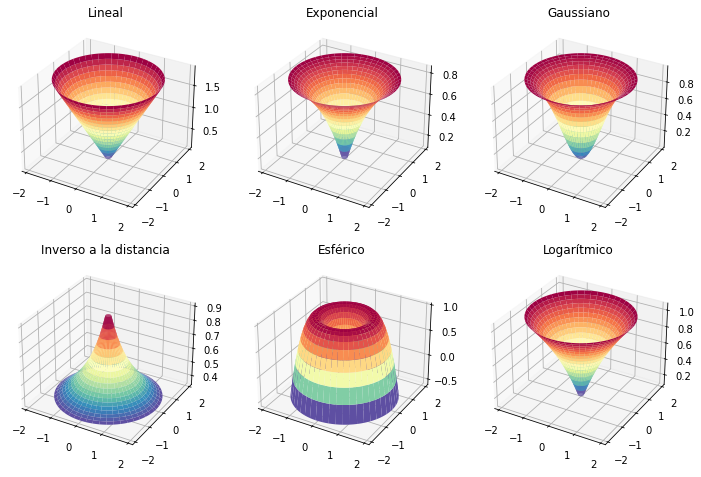

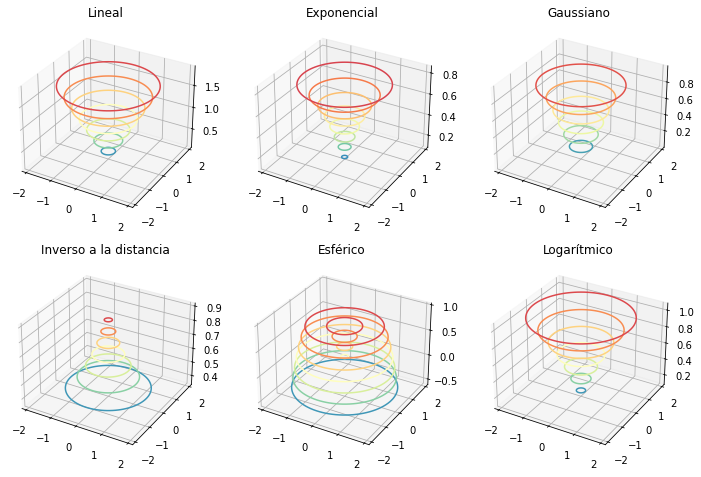

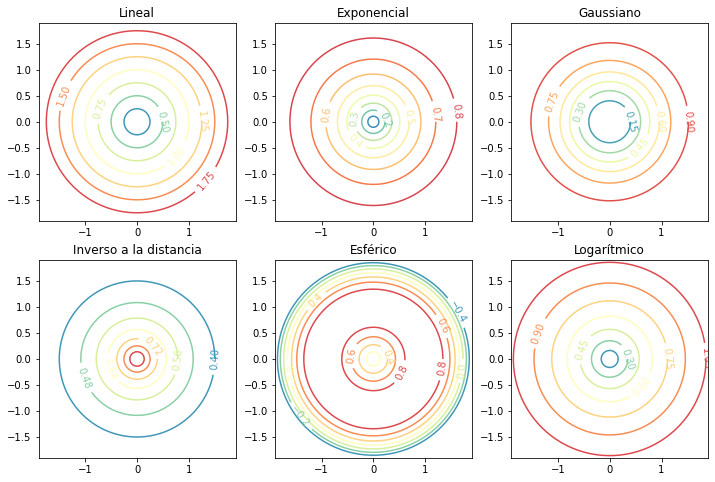

In [386]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la ecuación
c0 = 0
c = 1
a = 1

# Crear un rango de distancias y ángulos
r = np.arange(0.1,2,0.1)
theta = np.linspace(0, 2 * np.pi, 100)  # ángulos en radianes

# Crear una malla de coordenadas
R, Theta = np.meshgrid(r, theta)

# Convertir coordenadas polares a cartesianas
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Calcular los valores de z usando una ecuación lineal dependiente de r
lineal = c0 + c*(R/a) # Modelo lineal
exponencial =  c0 + c*(1-np.exp(-(R)/a)) # Modelo exponencial
gausiano = c0 + c*(1-np.exp(-((R/a)**2))) # Modelo Gausiano
inverso_distancia = c0 + c/(R + 1) # Modelo inverso a la distancia
esferico = c0 + c*(((3*R)/(2*a)) - ((R**3)/(2*(a**3))))
logaritmico = c0 + c*np.log(R + 1)
#propuesta = c0 + c*((X)*3 + (Y*1)*1)

# Graficar 3D 360°
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(231, projection='3d')
ax.set_title('Lineal')
ax.plot_surface(X, Y, lineal, cmap='Spectral_r')

ax2 = fig.add_subplot(232, projection = '3d')
ax2.set_title("Exponencial")
ax2.plot_surface(X, Y, exponencial, cmap='Spectral_r')

ax3 = fig.add_subplot(233, projection = '3d')
ax3.set_title("Gaussiano")
ax3.plot_surface(X, Y, gausiano, cmap='Spectral_r')

ax4 = fig.add_subplot(234, projection = '3d')
ax4.set_title("Inverso a la distancia")
ax4.plot_surface(X, Y, inverso_distancia, cmap='Spectral_r')

ax5 = fig.add_subplot(235, projection = '3d')
ax5.set_title("Esférico")
ax5.plot_surface(X, Y, esferico, cmap='Spectral_r')

ax6 = fig.add_subplot(236, projection = '3d')
ax6.set_title("Logarítmico")
ax6.plot_surface(X, Y, logaritmico, cmap='Spectral_r')

plt.show()

# Graficar contornos en 3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(231, projection='3d')
ax.set_title('Lineal')
CS = ax.contour(X, Y, lineal, cmap='Spectral_r')
ax.clabel(CS, inline=True, fontsize=10)

ax2 = fig.add_subplot(232, projection = '3d')
ax2.set_title("Exponencial")
CS = ax2.contour(X, Y, exponencial, cmap='Spectral_r')
ax2.clabel(CS, inline=True, fontsize=10)

ax3 = fig.add_subplot(233, projection = '3d')
ax3.set_title("Gaussiano")
CS = ax3.contour(X, Y, gausiano, cmap='Spectral_r')
ax3.clabel(CS, inline=True, fontsize=10)

ax4 = fig.add_subplot(234, projection = '3d')
ax4.set_title("Inverso a la distancia")
CS = ax4.contour(X, Y, inverso_distancia, cmap='Spectral_r')
ax4.clabel(CS, inline=True, fontsize=10)

ax5 = fig.add_subplot(235, projection = '3d')
ax5.set_title("Esférico")
CS = ax5.contour(X, Y, esferico, cmap='Spectral_r')
ax5.clabel(CS, inline=True, fontsize=10)

ax6 = fig.add_subplot(236, projection = '3d')
ax6.set_title("Logarítmico")
CS = ax6.contour(X, Y, logaritmico, cmap='Spectral_r')
ax6.clabel(CS, inline=True, fontsize=10)

plt.show()

# Graficar contornos en 2D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(231)
ax.set_title('Lineal')
CS = ax.contour(X, Y, lineal, cmap='Spectral_r')
ax.clabel(CS, inline=True, fontsize=10)

ax2 = fig.add_subplot(232)
ax2.set_title("Exponencial")
CS = ax2.contour(X, Y, exponencial, cmap='Spectral_r')
ax2.clabel(CS, inline=True, fontsize=10)

ax3 = fig.add_subplot(233)
ax3.set_title("Gaussiano")
CS = ax3.contour(X, Y, gausiano, cmap='Spectral_r')
ax3.clabel(CS, inline=True, fontsize=10)

ax4 = fig.add_subplot(234)
ax4.set_title("Inverso a la distancia")
CS = ax4.contour(X, Y, inverso_distancia, cmap='Spectral_r')
ax4.clabel(CS, inline=True, fontsize=10)

ax5 = fig.add_subplot(235)
ax5.set_title("Esférico")
CS = ax5.contour(X, Y, esferico, cmap='Spectral_r')
ax5.clabel(CS, inline=True, fontsize=10)

ax6 = fig.add_subplot(236)
ax6.set_title("Logarítmico")
CS = ax6.contour(X, Y, logaritmico, cmap='Spectral_r')
ax6.clabel(CS, inline=True, fontsize=10)

plt.show()

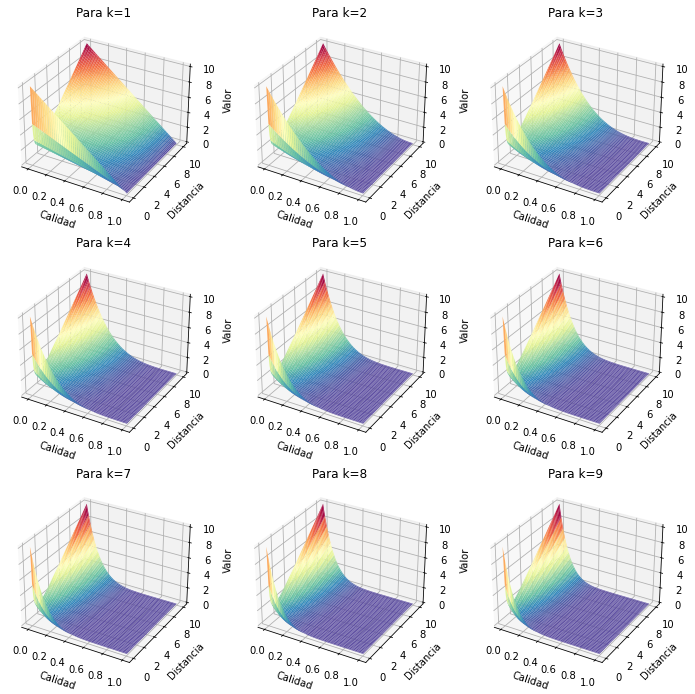

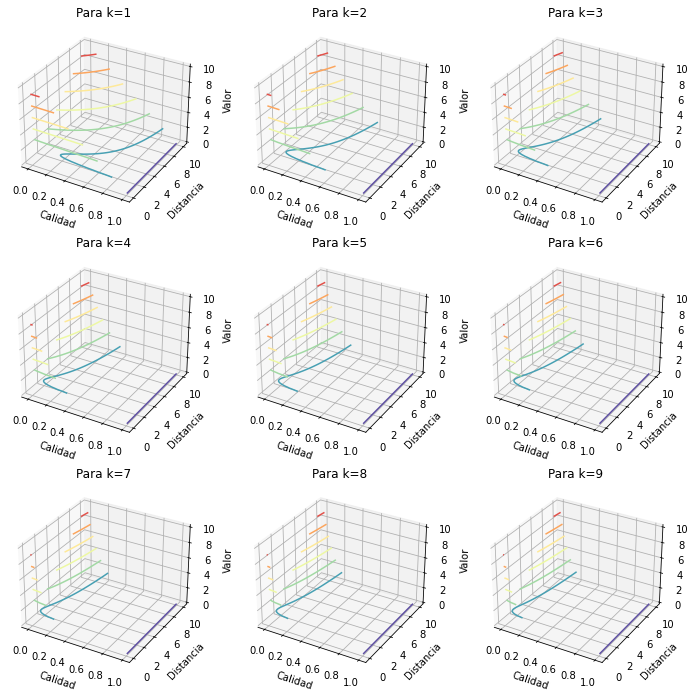

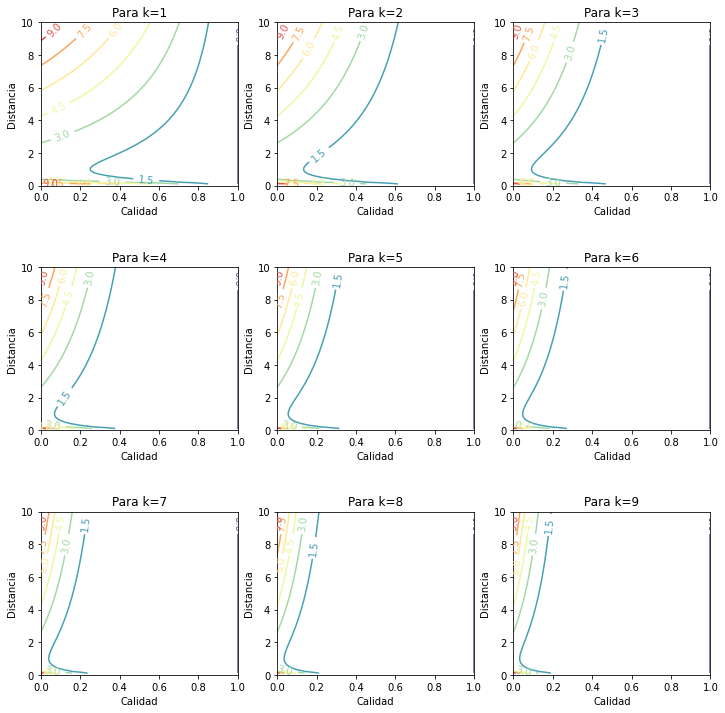

"\nfig = plt.figure(figsize=(12,12))\n\n# Calcular los valores de Z (por ejemplo, una combinación de distancia y calidad)\nZ = c0 + c*(10*(1-C)+D # Ajusta la ecuación según lo que necesites\n\n# Graficar\nax = fig.add_subplot(111, projection='3d')\nax.plot_surface(C, D, Z, cmap='Spectral_r')\n\nax.set_xlabel('Calidad')\nax.set_ylabel('Distancia')\nax.set_zlabel('Valor')\n\nplt.show()\n"

In [1042]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros de la ecuación
c0 = 0
c = 1
a = 1

# Crear un rango de distancias y calidad
distancia = np.linspace(0, 10, 100)  # distancia
calidad = np.linspace(0, 1, 100)  # calidad

# Crear una malla de coordenadas
D, C = np.meshgrid(distancia, calidad)


fig = plt.figure(figsize=(12,12))
for k in range(1,10):

    # Calcular los valores de Z (por ejemplo, una combinación de distancia y calidad)
    Z = c0 + c*((D*(1-C)**k)+(((1-C)**k)/D)) # Ajusta la ecuación según lo que necesites

    # Graficar
    ax = fig.add_subplot(3,3,k, projection='3d')
    ax.plot_surface(C, D, Z, cmap='Spectral_r')

    ax.set_xlabel('Calidad')
    ax.set_ylabel('Distancia')
    ax.set_zlabel('Valor')
    ax.set_title('Para k='+str(k))

plt.show()

fig = plt.figure(figsize=(12,12))
for k in range(1,10):
    Z = c0 + c*((D*(1-C)**k)+(((1-C)**k)/D))

    ax = fig.add_subplot(3,3,k, projection = '3d')
    CS = ax.contour(C, D, Z, cmap='Spectral_r')
    ax.clabel(CS, inline=True, fontsize=10)

    ax.set_xlabel('Calidad')
    ax.set_ylabel('Distancia')
    ax.set_zlabel('Valor')
    ax.set_title('Para k='+str(k))

plt.show()

fig = plt.figure(figsize=(12,12))
for k in range(1,10):
    Z = c0 + c*((D*(1-C)**k)+(((1-C)**k)/D))
    
    ax = fig.add_subplot(3,3,k)
    CS = ax.contour(C, D, Z, cmap='Spectral_r')
    ax.clabel(CS, inline=True, fontsize=10)

    ax.set_xlabel('Calidad')
    ax.set_ylabel('Distancia')
    ax.set_title('Para k='+str(k))

plt.subplots_adjust(hspace=0.5)
plt.show()

'''
fig = plt.figure(figsize=(12,12))

# Calcular los valores de Z (por ejemplo, una combinación de distancia y calidad)
Z = c0 + c*(10*(1-C)+D # Ajusta la ecuación según lo que necesites

# Graficar
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(C, D, Z, cmap='Spectral_r')

ax.set_xlabel('Calidad')
ax.set_ylabel('Distancia')
ax.set_zlabel('Valor')

plt.show()
'''

Text(0.5, 0, 'Incertidumbre')

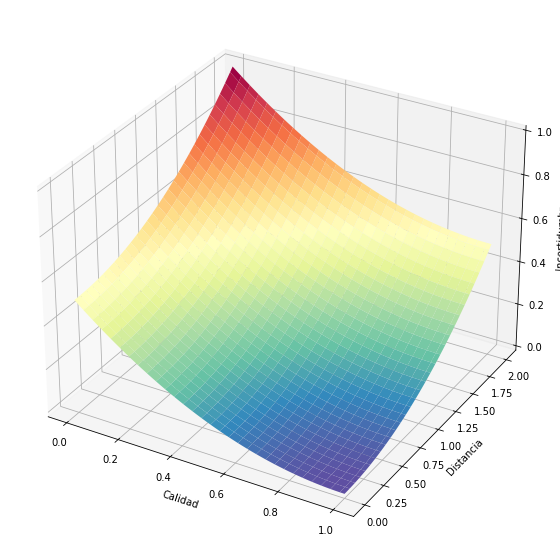

In [1260]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

a = 2
p = 3
x = np.linspace(0,1,60)
y = np.linspace(0,a,60)

xx, yy = np.meshgrid(x,y)

#z = (xx-2)**2 + (yy+2)**2 -np.exp(((xx-2)-(yy+2))/2) # Ecuación base, NO MODIFICAR X=(-2,2), Y=(-2,2)
#z = (p*xx-p)**2 + ((p*yy/a))**2 -np.exp(((p*xx-p)-((p*yy/a)))/2)
z= ((xx - 1)**2 + (yy/a)**2)/2
#z = a*((1-xx)+yy)

surf = ax.plot_surface(xx, yy, z, cmap="Spectral_r")

ax.set_xlabel('Calidad')      # <====== This works
ax.set_ylabel('Distancia') # <====== This doesn't work
ax.set_zlabel('Incertidumbre') # <====== This doesn't work

Nugget (c0): -688.22, Sill (c): 250.00, Range (a): -101.26


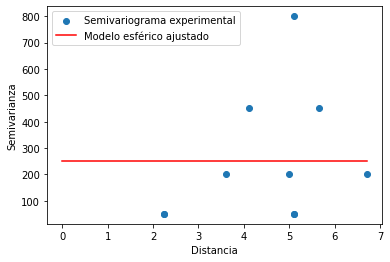

In [1243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ejemplo de datos (coordenadas y valores)
data = {
    'x': np.array([1, 2, 3, 5, 6]),
    'y': np.array([4, 2, 7, 8, 3]),
    'values': np.array([10, 20, 30, 40, 50])
}

# Función para calcular distancias entre puntos
def calculate_distancess(x, y):
    n = len(x)
    distances = []
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            distances.append(dist)
    return np.array(distances)

# Función para calcular el semivariograma experimental
def calculate_semivariogramm(values):
    n = len(values)
    semivariances = []
    for i in range(n):
        for j in range(i+1, n):
            gamma = 0.5 * (values[i] - values[j])**2
            semivariances.append(gamma)
    return np.array(semivariances)

# Cálculo de distancias y semivarianzas
distances = calculate_distancess(data['x'], data['y'])
semivariances = calculate_semivariogramm(data['values'])

# Definir el modelo esférico para ajustar el semivariograma
def spherical_model(h, c0, c, a):
    return np.where(h <= a, c0 + (c - c0) * (1.5 * (h / a) - 0.5 * (h / a) ** 3), c)

# Ajustar el modelo esférico a los datos experimentales
popt, pcov = curve_fit(spherical_model, distances, semivariances, p0=[0, 10, 5])

# Obtener los parámetros ajustados (nugget, sill, range)
c0, c, a = popt
print(f'Nugget (c0): {c0:.2f}, Sill (c): {c:.2f}, Range (a): {a:.2f}')

# Gráfico del semivariograma experimental y el modelo ajustado
plt.scatter(distances, semivariances, label='Semivariograma experimental')
h_vals = np.linspace(0, np.max(distances), 100)
plt.plot(h_vals, spherical_model(h_vals, *popt), color='red', label='Modelo esférico ajustado')
plt.xlabel('Distancia')
plt.ylabel('Semivarianza')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def calculate_experimental_semivariance(coordinates, values, lags, tolerance):
    """
    Calcula la semivarianza experimental de un conjunto de puntos.

    Parameters:
    -----------
    coordinates : np.array
        Matriz de coordenadas de los puntos (latitud y longitud) con forma (n, 2).
    values : np.array
        Array con los valores de la variable de interés en cada punto.
    lags : list
        Lista de intervalos de distancia (lags) para calcular la semivarianza.
    tolerance : float
        Tolerancia para definir los límites de cada lag (+/-) en las distancias.

    Returns:
    --------
    semivariances : pd.DataFrame
        DataFrame con los resultados de la semivarianza experimental.
    """
    # Calcular la distancia entre cada par de puntos
    distances = pdist(coordinates, metric='euclidean')  # Distancias entre pares de puntos
    distance_matrix = squareform(distances)  # Convertir a matriz cuadrada para manipulación
    
    # Calcular la diferencia al cuadrado de los valores entre cada par de puntos
    n_points = len(values)
    squared_diffs = np.zeros((n_points, n_points))  # Matriz de diferencias cuadráticas
    for i in range(n_points):
        for j in range(i+1, n_points):
            squared_diffs[i, j] = (values[i] - values[j])**2

    # Preparar los resultados en un DataFrame
    results = {"Lag": [], "Semivariance": [], "Number of Pairs": []}

    # Calcular la semivarianza para cada lag
    for lag in lags:
        # Definir el rango de distancias para el lag actual
        lower_bound = lag - tolerance
        upper_bound = lag + tolerance

        # Encontrar los pares que caen dentro de este rango de distancias
        pairs = np.where((distances >= lower_bound) & (distances <= upper_bound))[0]

        if len(pairs) > 0:
            # Sumar las diferencias cuadráticas para los pares dentro del lag actual
            semivariance = np.sum([squared_diffs[i, j] for (i, j) in np.triu_indices_from(squared_diffs) if (distances[(i * n_points + j) - int(i * (i + 1) / 2)] >= lower_bound) and (distances[(i * n_points + j) - int(i * (i + 1) / 2)] <= upper_bound)])

            # Calcular la semivarianza promedio
            semivariance /= (2 * len(pairs))  # Fórmula de semivarianza

            # Almacenar los resultados
            results["Lag"].append(lag)
            results["Semivariance"].append(semivariance)
            results["Number of Pairs"].append(len(pairs))

    return pd.DataFrame(results)

# Ejemplo de uso:
# Definir las coordenadas de los puntos y los valores observados
coordinates = np.array([[1, 2], [2, 3], [3, 4], [5, 6], [7, 8]])  # Coordenadas (lat, lon)
values = np.array([10, 12, 15, 18, 20])  # Valores de la variable en cada punto

# Definir los lags (distancias en las que se agruparán los pares) y la tolerancia
lags = [1, 2, 3, 4, 5]
tolerance = 0.5

# Calcular la semivarianza experimental
semivariance_df = calculate_experimental_semivariance(coordinates, values, lags, tolerance)
print(semivariance_df)

C:\Users\Fernando Avila\AppData\Local\Temp\ipykernel_33276\3893867205.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mapa['centroid'] = mapa.centroid


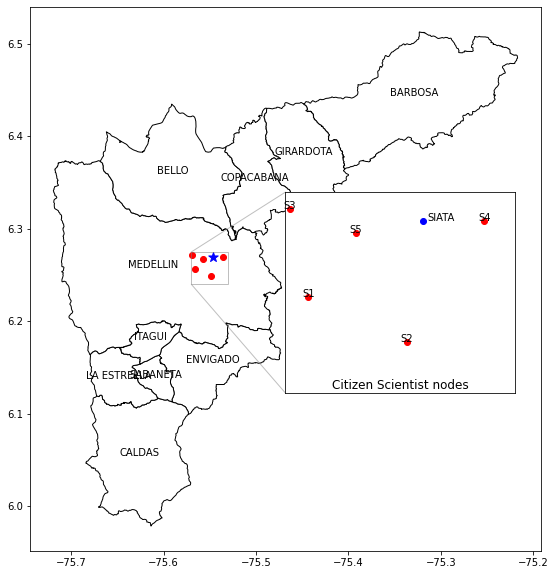


Dist a interpolación: [0.024, 0.0213, 0.0233, 0.0106, 0.012]
Matriz covarianzas: [39.9704, 44.8464, 41.1759, 86.2069, 76.9034]
Pesos de los sensores: [1.2559, -0.405, 1.4684, -2.3913, 0.5989]
0.5268999999999999
Valores de los sensores: [35, 43, 30, 45, 39]
Valor con Kriging clásico: -13.657900000000016

Dist a interpolación: [0.024, 0.0213, 0.0233, 0.0106, 0.012]
Matriz covarianzas: [25.9807, 24.6655, 9.8822, 56.0345, 53.8324]
Pesos de los sensores: [1.9321, -0.7364, 6.1185, -3.6789, 0.8556]
4.4909
Valor con Kriging modificado: 87.33119999999998

Dist a interpolación: [0.024, 0.0213, 0.0233, 0.0106, 0.012]
Matriz covarianzas: [37.1153, 35.2364, 14.1175, 80.0493, 76.9034]
Pesos de los sensores: [1.3525, -0.5155, 4.2829, -2.5752, 0.5989]
3.1435999999999993
Valor con Kriging modificado con DQ Index Normalizado: 61.13109999999998


In [87]:
import numpy as np
import pandas as pd

data = {
    'Sensor': ["S1", "S2", "S3", "S4", "S5"],
    'lat': [6.256, 6.2567, 6.2720, 6.268, 6.269],
    'lon': [-75.567, -75.5660, -75.5692, -75.5455, -75.5456],
    'DQIndex': [0.1, 0.99, 0.01, 0.99, 0.1],
    'values': [35, 43, 30, 45, 39]
}
#6.275
interpolation_point = {
    'lat': [6.270],
    'lon': [-75.5460]
}

# Creación de DataFrames
sensors_df = pd.DataFrame(data)
interpolation_df = pd.DataFrame(interpolation_point)

sensor_values = list(sensors_df["values"])

# Calcular la distancia entre cada sensor y el punto de interpolación
sensors_df['Distance_to_Interpolation'] = np.sqrt(
    (sensors_df['lat'] - interpolation_df['lat'].values[0])**2 + 
    (sensors_df['lon'] - interpolation_df['lon'].values[0])**2
)

# Calcular la matriz de distancias entre sensores (para el variograma)
num_sensors = len(sensors_df)
distance_matrix = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        distance_matrix[i, j] = np.sqrt(
            (sensors_df['lat'][i] - sensors_df['lat'][j])**2 + 
            (sensors_df['lon'][i] - sensors_df['lon'][j])**2
        )

dibuja_mapa(sensors_df, interpolation_df)

########## INICIO KRIGING CLÁSICO ###############

# Paso 1: Construcción de la matriz de covarianzas 
covariance_matrix_weighted = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        if i != j:
            covariance_matrix_weighted[i, j] = 1 / (distance_matrix[i, j] + 0.001)
        else:
            covariance_matrix_weighted[i, j] = 1

print("\nDist a interpolación:",list(round(sensors_df['Distance_to_Interpolation'], 4)))

# Paso 2: Vector de covarianzas entre los sensores y el punto de interpolación, 
cov_vector_weighted = 1 / (sensors_df['Distance_to_Interpolation'].values + 0.001)
cov_vector_weighted = [round(elem, 4) for elem in cov_vector_weighted ]
print("Matriz covarianzas:", cov_vector_weighted)

# Paso 3: Resolución del sistema lineal C * lambda = c para encontrar los pesos lambda
lambda_weights_weighted = np.linalg.solve(covariance_matrix_weighted, cov_vector_weighted)
lambda_weights_weighted = [round(elem, 4) for elem in lambda_weights_weighted ]
print("Pesos de los sensores:",lambda_weights_weighted)
print(sum(lambda_weights_weighted))

# Paso 4: Cálculo del valor interpolado usando el Kriging Modificado con DQ Index Normalizado
interpolated_value_weighted = np.dot(lambda_weights_weighted, sensor_values)

print("Valores de los sensores:",sensor_values)
print("Valor con Kriging clásico:",interpolated_value_weighted)

########## FIN KRIGING CLÁSICO ###############

########## INICIO KRIGING MODIFICADO ###############

dq_index = np.array(sensors_df["DQIndex"])

# Paso 1: Construcción de la matriz de covarianzas usando las ponderaciones del DQ Index normalizado
covariance_matrix_weighted = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        if i != j:
            covariance_matrix_weighted[i, j] = (dq_index[i] * dq_index[j]) / (distance_matrix[i, j] + 0.001)
        else:
            covariance_matrix_weighted[i, j] = dq_index[i]**2

print("\nDist a interpolación:",list(round(sensors_df['Distance_to_Interpolation'], 4)))

# Paso 2: Vector de covarianzas entre los sensores y el punto de interpolación, usando el DQ Index normalizado
cov_vector_weighted = dq_index / (sensors_df['Distance_to_Interpolation'].values + 0.001)
cov_vector_weighted = [round(elem, 4) for elem in cov_vector_weighted ]
print("Matriz covarianzas:", cov_vector_weighted)

# Paso 3: Resolución del sistema lineal C * lambda = c para encontrar los pesos lambda
lambda_weights_weighted = np.linalg.solve(covariance_matrix_weighted, cov_vector_weighted)
lambda_weights_weighted = [round(elem, 4) for elem in lambda_weights_weighted ]
print("Pesos de los sensores:",lambda_weights_weighted)
print(sum(lambda_weights_weighted))

# Paso 4: Cálculo del valor interpolado usando el Kriging Modificado con DQ Index Normalizado
interpolated_value_weighted = np.dot(lambda_weights_weighted, sensor_values)

print("Valor con Kriging modificado:",interpolated_value_weighted)

########## FIN KRIGING MODIFICADO ###############

########## INICIO KRIGING MODIFICADO CON DQ INDEX NORMALIZADO ###############

dq_index = np.array(sensors_df["DQIndex"])

# Normalización del DQ Index
max_dq_index = dq_index.max()
dq_index_normalized = dq_index / max_dq_index

# Paso 1: Construcción de la matriz de covarianzas usando las ponderaciones del DQ Index normalizado
covariance_matrix_weighted = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        if i != j:
            covariance_matrix_weighted[i, j] = (dq_index_normalized[i] * dq_index_normalized[j]) / (distance_matrix[i, j] + 0.001)
        else:
            covariance_matrix_weighted[i, j] = dq_index_normalized[i]**2

print("\nDist a interpolación:",list(round(sensors_df['Distance_to_Interpolation'], 4)))
# Paso 2: Vector de covarianzas entre los sensores y el punto de interpolación, usando el DQ Index normalizado
cov_vector_weighted = dq_index_normalized / (sensors_df['Distance_to_Interpolation'].values + 0.001)
cov_vector_weighted = [round(elem, 4) for elem in cov_vector_weighted ]
print("Matriz covarianzas:", cov_vector_weighted)

# Paso 3: Resolución del sistema lineal C * lambda = c para encontrar los pesos lambda
lambda_weights_weighted = np.linalg.solve(covariance_matrix_weighted, cov_vector_weighted)
lambda_weights_weighted = [round(elem, 4) for elem in lambda_weights_weighted ]
print("Pesos de los sensores:",lambda_weights_weighted)
print(sum(lambda_weights_weighted))

# Paso 4: Cálculo del valor interpolado usando el Kriging Modificado con DQ Index Normalizado
interpolated_value_weighted = np.dot(lambda_weights_weighted, sensor_values)

print("Valor con Kriging modificado con DQ Index Normalizado:",interpolated_value_weighted)

########## FIN KRIGING MODIFICADO CON DQ INDEX NORMALIZADO ###############


In [88]:
import numpy as np
from scipy.linalg import solve

# 1. Calcular distancias entre sensores y el punto de interpolación
def calculate_distances(data, interp_point):
    distances = []
    for i in range(len(data['Sensor'])):
        d = np.sqrt((data['lat'][i] - interp_point['lat'][0]) ** 2 +
                     (data['lon'][i] - interp_point['lon'][0]) ** 2)
        distances.append(d)
    return distances

distances = calculate_distances(data, interpolation_point)

# 2. Normalizar el DQ Index
max_dq_index = max(data['DQIndex'])
normalized_dq_index = [dq / max_dq_index for dq in data['DQIndex']]

# 3. Construir la matriz de covarianzas
def covariance_matrix(distances, normalized_dq_index):
    n = len(distances)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                C[i, j] = normalized_dq_index[i] ** 2
            else:
                C[i, j] = (normalized_dq_index[i] * normalized_dq_index[j]) / (distances[i] + 0.001)
    return C

C = covariance_matrix(distances, normalized_dq_index)

# 4. Vector de covarianzas c
def covariance_vector(distances, normalized_dq_index):
    c = np.array([normalized_dq_index[i] / (distances[i] + 0.001) for i in range(len(distances))])
    return c

c = covariance_vector(distances, normalized_dq_index)

# 5. Construir la matriz extendida
def extended_matrix(C):
    n = C.shape[0]
    ones = np.ones((n, 1))
    return np.block([[C, ones], [ones.T, 0]])

C_ext = extended_matrix(C)

# 6. Resolver el sistema
c_ext = np.append(c, 1)
lambda_mu = solve(C_ext, c_ext)
lambda_weights = lambda_mu[:-1]
mu = lambda_mu[-1]

# 7. Calcular el valor interpolado
def interpolated_value(data, lambda_weights):
    return np.sum(lambda_weights * data['values'])

value_interpolated = interpolated_value(data, lambda_weights)

# Mostrar el resultado
print(f"El valor interpolado en el punto {interpolation_point} es: {value_interpolated:.2f} y mu es: {mu}")
print(data["Sensor"])
print(lambda_weights, ", Suma:", round(sum(lambda_weights),4))
print(data["values"])
print(np.array(lambda_weights)*np.array(data["values"]))
print(data["DQIndex"])
print([round(elem, 4) for elem in distances ])

El valor interpolado en el punto {'lat': [6.27], 'lon': [-75.546]} es: 74.90 y mu es: -38.575101543751586
['S1', 'S2', 'S3', 'S4', 'S5']
[ 0.73375673  0.7926106  -3.07538726  1.33115889  1.21786103] , Suma: 1.0
[35, 43, 30, 45, 39]
[ 25.68148568  34.08225578 -92.26161766  59.90215001  47.49658028]
[0.65, 0.55, 0.24, 0.65, 0.7]
[0.024, 0.0213, 0.0233, 0.0106, 0.012]


In [ ]:
El valor interpolado en el punto {'lat': [6.255], 'lon': [-75.546]} es: 63.14
['S1', 'S2', 'S3', 'S4', 'S5']
[ 0.63462732  1.06234072 -2.04324258  0.67303999  0.67323455] , Suma: 1.0
[35, 43, 30, 45, 39]
[ 22.21195636  45.68065079 -61.29727753  30.28679962  26.25614754]
[0.65, 0.55, 0.24, 0.65, 0.7]
[0.0201, 0.0068, 0.0288, 0.0184, 0.0174]

### IDW (Interpolación Inversa Ponderada)

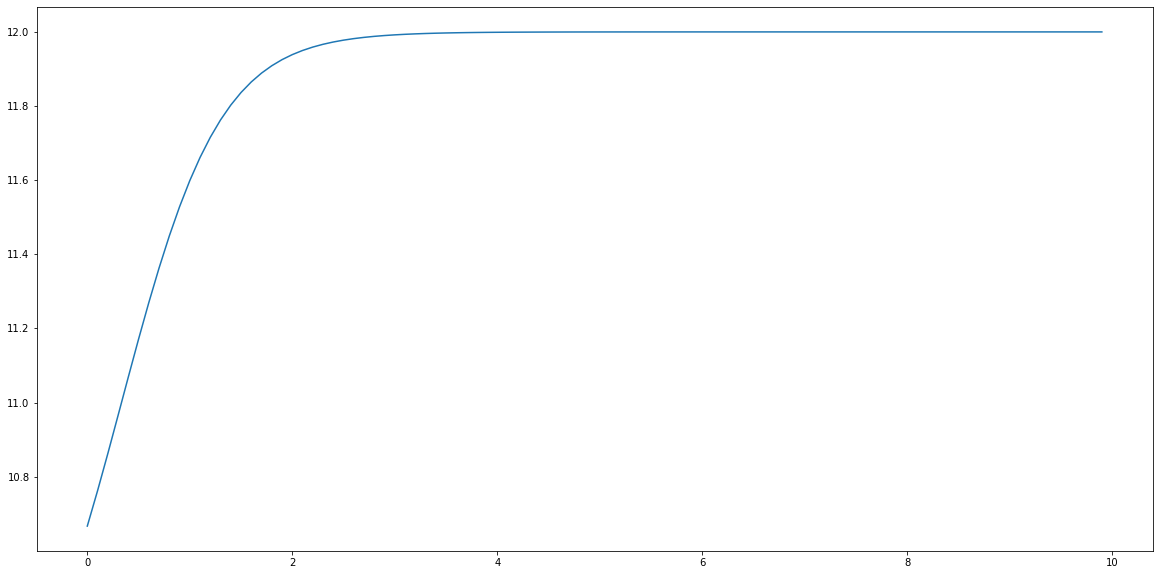

In [64]:
import numpy as np
import matplotlib.pyplot as plt

values = [12, 10, 10]
distances = [100, 750, 850]


p = 3
results = []

for p in np.arange(0,10,0.1):
    num = 0
    denom = 0
    for val,dis in zip(values, distances):
        num = num + (val/(dis**p))
        denom = denom + (1/(dis**p))

    results.append(num/denom)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(0,10,0.1), results)
plt.show()


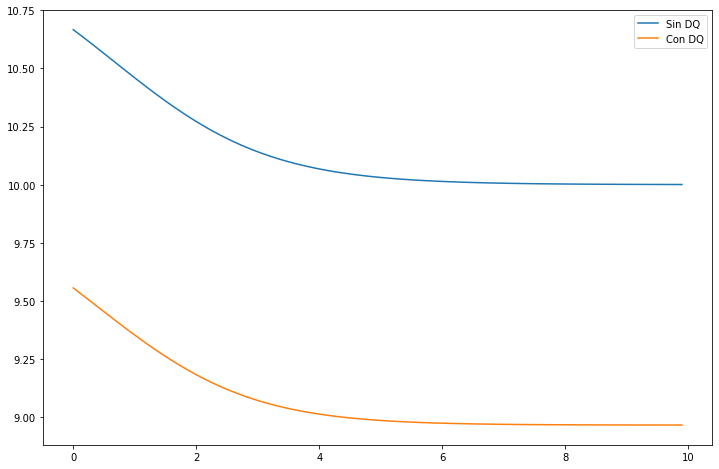

In [2]:
import numpy as np
import matplotlib.pyplot as plt

values = [12, 10, 10]
distances = [800, 750, 350]
DQIndex = [0.87, 0.67, 0.78]
DQIndex = list(map(lambda x: x / max(DQIndex), DQIndex))


p = 3
results1 = []
results2 = []

for p in np.arange(0,10,0.1):
    num1 = 0
    num2 = 0
    denom1 = 0
    denom2 = 0
    for val,dis,quality in zip(values, distances, DQIndex):
        num1 = num1 + (val/(dis**p))
        denom1 = denom1 + (1/(dis**p))
        num2 = num2 + ((val*quality)/(dis**p))
        denom2 = denom2 + (1/(dis**p))

    results1.append(num1/denom1)
    results2.append(num2/denom2)

plt.figure(figsize=(12, 8))
plt.plot(np.arange(0,10,0.1), results1, label="Sin DQ")
plt.plot(np.arange(0,10,0.1), results2, label="Con DQ")
plt.legend()
plt.show()

In [113]:
values = [12, 10, 10]
distances = [850, 750, 350]
DQIndex = [0.87, 0.67, 0.78]

'''
divi = [a/b for a,b in zip(distances, DQIndex)]

res_resta = [abs(a-b) for a,b in zip(distances, divi)]
res_resta
'''

divi = abs(sum(distances)-np.array(distances))
divi = divi/sum(divi)
print(divi)
res_resta = np.array(DQIndex)/sum(DQIndex)
print(res_resta)

sum(divi*res_resta)


[0.28205128 0.30769231 0.41025641]
[0.375     0.2887931 0.3362069]


0.3325596816976127